# RetinaMNIST with rotations

In this exercise your goal will be to solve an object detection training and prediction task using the anchor-based approach.
**As a part of your solution you should provide a report summarizing your findings and results of the conducted experiments.**

##TLDR; overview

In this task one should:
- determine the size of the feasible anchors for the object detection task posed in this Assignment,
- build an object detection model using the variant of `RetinaNet`,
- prepare a matching suite which will match predicted anchors with ground truth bounding boxes,
- train an object detection model using a variant of `RetinaLoss`.

Hints and comments:

- Model architecture and loss are heavily inspired by [RetinaNet](https://arxiv.org/pdf/1708.02002.pdf) paper,
- you can freely subclass and extend the interface of classes in this exercise,
- be sure that you understand the concept of an anchor for object detection, covered during the lecture about Object Detection. There are many great tutorials and articles about it (e.g. [this](https://towardsdatascience.com/anchor-boxes-the-key-to-quality-object-detection-ddf9d612d4f9) one, note however that we are not implementing ignoring boxes for simplicity).

### Data description

In this task we will paste bounding boxes with digits **from 1 to 5** randomly selected from `MNIST` dataset on a canvas of size `(128, 128)` and **randomly flipped by 90 degrees**. We assume that:

- the two boxes from a canvas should have no more than `0.1` of `iou` overlap,
- the digits are fully contained in canvas,
- boxes are modeled using `MnistBox` class,
- canvas is modeled using `MnistCanvas` class.

Let us have a look at definition of these classes:

In [1]:
from typing import List
from typing import Optional
from typing import Tuple

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MnistBox:

    def __init__(
        self,
        x_min: int,
        y_min: int,
        x_max: int,
        y_max: int,
        class_nb: Optional[int] = None,
        rotated: Optional[bool] = None,
    ):
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.class_nb = class_nb
        self.rotated = rotated
    
    @property
    def x_diff(self):
        return self.x_max - self.x_min
    
    @property
    def y_diff(self):
        return self.y_max - self.y_min

    def __repr__(self):
        return f'Mnist Box: x_min = {self.x_min},' +\
               f' x_max = {self.x_max}, y_min = {self.y_min},' +\
               f' y_max = {self.y_max}. Class = {self.class_nb}.' +\
               f' Rotated = {self.rotated}.'

    def plot_on_ax(self, ax, color: Optional[str] = 'r'):
        ax.add_patch(
            patches.Rectangle(
                (self.y_min, self.x_min),
                 self.y_diff,
                 self.x_diff,
                 linewidth=1,
                 edgecolor=color,
                 facecolor='none',
            )
        )
        ax.text(
            self.y_min,
            self.x_min,
            f'{self.class_nb}' if not self.rotated else f'{self.class_nb}*',
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )

    @property
    def area(self):
        return max((self.x_max - self.x_min), 0) * max((self.y_max - self.y_min), 0)

    def iou_with(self, other_box: "MnistBox"):
        aux_box = MnistBox(
            x_min=max(self.x_min, other_box.x_min),
            x_max=min(self.x_max, other_box.x_max),
            y_min=max(self.y_min, other_box.y_min),
            y_max=min(self.y_max, other_box.y_max),
        ) 
        return aux_box.area / (self.area + other_box.area - aux_box.area)


class MnistCanvas:

    def __init__(
        self,
        image: np.ndarray,
        boxes: List[MnistBox],
    ):
        self.image = image
        self.boxes = boxes

    def add_digit(
        self,
        digit: np.ndarray,
        class_nb: int,
        x_min: int,
        y_min: int,
        rotated=None,
        iou_threshold=0.1,
    ) -> bool:
        """
        Add a digit to an image if it does not overlap with existing boxes
        above iou_threshold.
        """
        image_x, image_y = digit.shape
        if x_min >= self.image.shape[0] and y_min >= self.image.shape[1]:
            raise ValueError('Wrong initial corner box')
        new_box_x_min = x_min
        new_box_y_min = y_min
        new_box_x_max = min(x_min + image_x, self.image.shape[0])
        new_box_y_max = min(y_min + image_y, self.image.shape[1])
        new_box = MnistBox(
            x_min=new_box_x_min,
            x_max=new_box_x_max,
            y_min=new_box_y_min,
            y_max=new_box_y_max,
            class_nb=class_nb,
            rotated=rotated,
        )
        old_background = self.image[
            new_box_x_min:new_box_x_max,
            new_box_y_min:new_box_y_max
        ]
        for box in self.boxes:
            if new_box.iou_with(box) > iou_threshold:
                return False
        self.image[
            new_box_x_min:new_box_x_max,
            new_box_y_min:new_box_y_max
        ] = np.maximum(old_background, digit)
        self.boxes.append(
            new_box
        ) 
        return True
        
    def get_torch_tensor(self) -> torch.Tensor:
        np_image = self.image.astype('float32')
        np_image = np_image.reshape(
            (1, 1, self.image.shape[0], self.image.shape[1])
        )
        return torch.from_numpy(np_image).to(DEVICE)

    @classmethod
    def get_empty_of_size(cls, size: Tuple[int, int]):
        return cls(
            image=np.zeros(size),
            boxes=[],
        )

    def plot(self, boxes: Optional[List[MnistBox]] = None):
        fig, ax = plt.subplots()
        ax.imshow(self.image)
        boxes = boxes or self.boxes
        for box in boxes:
            if box is not None:
                box.plot_on_ax(ax)
        plt.show()

Each canvas has 3-6 boxes with randomly selected digits. The digits for training data are from first 10K examples from `MNIST` train data. The digits for test data are selected from first 1K examples from `MNIST` test data. The Dataset is generated using the following functions:

In [2]:
from keras.datasets import mnist
import numpy as np


mnist_data = mnist.load_data()
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist_data


def crop_insignificant_values(digit:np.ndarray, threshold=0.1):
    bool_digit = digit > threshold
    x_range = bool_digit.max(axis=0)
    y_range = bool_digit.max(axis=1)
    start_x = (x_range.cumsum() == 0).sum()
    end_x = (x_range[::-1].cumsum() == 0).sum()
    start_y = (y_range.cumsum() == 0).sum()
    end_y = (y_range[::-1].cumsum() == 0).sum()
    return digit[start_y:-end_y - 1, start_x:-end_x - 1]


TRAIN_DIGITS = [
    crop_insignificant_values(digit) / 255.0
    for digit_index, digit in enumerate(mnist_x_train[:10000])
]
TRAIN_CLASSES = mnist_y_train[:10000]

TEST_DIGITS = [
    crop_insignificant_values(digit) / 255.0
    for digit_index, digit in enumerate(mnist_x_test[:1000])
]
TEST_CLASSES = mnist_y_test[:1000]


def get_random_canvas(
    digits: Optional[List[np.ndarray]] = None,
    classes: Optional[List[int]] = None,
    nb_of_digits: Optional[int] = None,
    ):
    digits = digits if digits is not None else TRAIN_DIGITS
    classes = classes if classes is not None else TRAIN_CLASSES
    nb_of_digits = nb_of_digits if nb_of_digits is not None else np.random.randint(low=3, high=6 + 1)
    new_canvas = MnistCanvas.get_empty_of_size(size=(128, 128))
    attempts_done = 0
    while attempts_done < nb_of_digits:
        current_digit_index = np.random.randint(len(digits))
        current_digit_class = classes[current_digit_index]
        if current_digit_class not in [1, 2, 3, 4, 5]:
            continue
        rotate = np.random.random() > 0.5
        current_digit = digits[current_digit_index]
        if rotate:
            current_digit = np.rot90(current_digit)
        random_x_min = np.random.randint(0, 128 - current_digit.shape[0] - 3)
        random_y_min = np.random.randint(0, 128 - current_digit.shape[1] - 3)
        if new_canvas.add_digit(
            digit=current_digit,
            x_min=random_x_min,
            y_min=random_y_min,
            class_nb=current_digit_class,
            rotated=rotate,
        ):
            attempts_done += 1
    return new_canvas

11501568/11490434 [==============================] - 0s 0us/step


Let us have a look at example canvas (rotated digits have additional *added to description).

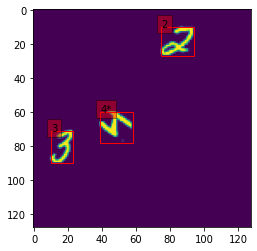

In [3]:
mnist_canvas = get_random_canvas()
mnist_canvas.plot()

Now - let us generate test canvas:

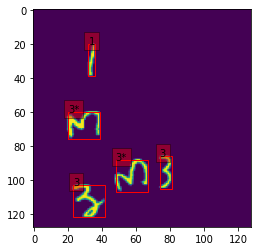

In [4]:
TEST_CANVAS_SIZE = 256
TEST_SEED = 42 # DO NOT CHANGE THIS LINE.

np.random.seed(TEST_SEED)

TEST_CANVAS = [
    get_random_canvas(
        digits=TEST_DIGITS,
        classes=TEST_CLASSES,
    )
    for _ in range(TEST_CANVAS_SIZE)
]

TEST_CANVAS[0].plot()

For training one can either:
- generate `TRAIN_CANVAS` similarly to `TEST_CANVAS` creation,
- use the fact that `get_random_canvas()` generates a random train canvas and generate training data on-the-fly.

### Anchor size analysis (2pts)

For this task:
1. Sample at least 1000 random canvas.
2. Analyze the sizes (heights and widths) of the `MnistBox`es from this canvas.
3. Select the anchor sizes which will match the problem the best.

Selected anchor sizes should be stored in a sensible manner in `ANCHOR_SIZES` list.

In [5]:
import collections
import matplotlib.pyplot as plt
import plotly.express as px

ANALYZE_CANVAS_SIZE = 1000

ANALYZE_CANVAS = [
    get_random_canvas(
        digits=TRAIN_DIGITS,
        classes=TRAIN_CLASSES,
    )
    for _ in range(ANALYZE_CANVAS_SIZE)
]

y_len = []
x_len = []

for canvas in ANALYZE_CANVAS:
    for box in canvas.boxes:
        x_len.append(box.x_diff)
        y_len.append(box.y_diff)

xy_len = np.concatenate([np.array(x_len).reshape(-1, 1), np.array(y_len).reshape(-1, 1)],
                        axis=1)
xy_len_unique, xy_len_count = np.unique(xy_len, axis=0, return_counts=True)
xy_len_unique_str = np.array([str(uq) for uq in xy_len_unique])

fig = px.bar(x=xy_len_unique_str, y=xy_len_count, labels={'x': 'size', 'y': 'count'})
fig.show()
# we can see that pairs are of type (19, x) and (x, 19) where x is in [2, 19]
# taking into consideration some shifts we should add to ANCHOR_SIZES also (x, y) and (y, x)
# where x is in [19, 23] and y in [2, 23]
# However, to decrease model training time, we choose most common values.

x_new = np.linspace(5, 19, 8, dtype=int)
y_new = np.linspace(5, 19, 8, dtype=int)
xy_len_new = np.array(np.meshgrid(x_new, y_new, indexing='ij')).T.reshape(-1, 2)

ANCHOR_SIZES = torch.Tensor(
    [[5, 19], [19, 5], [9, 19], [19, 9], [13, 19], [19, 13], [17, 19], [19, 17],
        [19, 19]]).to(DEVICE)
print(f"ANCHOR_SIZES:\nshape: {ANCHOR_SIZES.shape}\nvalues:\n{ANCHOR_SIZES}")

ANCHOR_SIZES:
shape: torch.Size([9, 2])
values:
tensor([[ 5., 19.],
        [19.,  5.],
        [ 9., 19.],
        [19.,  9.],
        [13., 19.],
        [19., 13.],
        [17., 19.],
        [19., 17.],
        [19., 19.]])


### Model building (2pt)


One should build a model for digit detection in $\texttt{pytorch}$. Model should consist of:

#### $\texttt{backbone}$:

We provided you with a backbone model architecture that accepts a `MnistCanvas` instance and output a tensor with shape $(1, 16, 16, 128)$. It should be trained together with the rest of your solution.

#### $\texttt{anchors}$:

List of `MnistBox`es where each box:

- should have size of one of selected `ANCHOR_SIZES`,
- should have center coordinates on canvas of type $\left(\left(m + \frac{1}{2}\right) * 8, \left(n + \frac{1}{2}\right) * 8\right)$  for $m, n \in \{0, 1, \dots, 16 - 1\}$,

`MnistBox` with anchor should have an attribute `class_nb` set to `None`.

#### $\texttt{digitClassificationHead}$:

$\texttt{digitClassificationHead}$ should accept backbone output as an input and output `digit_classification_output` tensor of shape $(len(\texttt{anchors)}, 5)$ where the value $ch_{i, j}$ which is the value of i-th row and j-th column has a property that $sigmoid(ch_{i, j})$ is a probability that i-th anchor from $\texttt{anchors}$ overlaps significantly with some canvas `GTBox: MnistBox` with a digit of class $j + 1$ (ground truth box).

#### $\texttt{rotationClassificationHead}$:

$\texttt{rotationClassificationHead}$ should accept backbone output as an input and output `rotation_classification_output` tensor of shape $(len(\texttt{anchors)}, 2)$ where the value $ch_{i, j}$ which is the value of i-th row and j-th column has a property that $sigmoid(ch_{i, j})$ is a probability that i-th anchor from $\texttt{anchors}$ overlaps significantly with some canvas `GTBox: MnistBox` with a digit which was not rotated when $j = 0$ and was rotated when $j = 1$.

#### $\texttt{boxRegressionHead}$:

$\texttt{boxRegressionHead}$ should accept backbone output as an input and output `box_regression_output` tensor of shape $(len(\texttt{anchors)}, 4)$ where the value $br_{i}$ which is the value of i-th row has a property that if there is a ground truth digit box $\texttt{GTBox}$ - significantly overlapping with $\texttt{anchor}[i]$ then the following properties hold:

$$\texttt{GTBox.x_min} = \texttt{anchor[i].x_min} + br_{i, 0},$$ 
$$\texttt{GTBox.x_max} = \texttt{anchor[i].x_max} + br_{i, 1},$$ 
$$\texttt{GTBox.y_min} = \texttt{anchor[i].y_min} + br_{i, 2},$$ 
$$\texttt{GTBox.y_max} = \texttt{anchor[i].y_max} + br_{i, 3}.$$ 

#### *Hint*: be careful with a construction of a head output as a simple reshaping might cause unexpected permutation of anchors.

### Model output

Model should output `DigitDetectionModelOutput` class defined below.

#### Comment on _significant overlap_:

The meaning of significant overlap will be described later.

In [6]:
#@title Default title text
from torch import nn


class DigitDetectionModelOutput:

    def __init__(
            self,
            anchors: List[MnistBox],
            digit_classification_output: torch.Tensor,
            rotation_classification_output: torch.Tensor,
            box_regression_output: torch.Tensor,
    ):
        self.anchors = anchors
        self.digit_classification_output = digit_classification_output
        self.box_regression_output = box_regression_output
        self.rotation_classification_output = rotation_classification_output


class Backbone(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.output_shape = (16, 16, 128)
        self.first_block = torch.nn.Sequential(
            nn.Conv2d(1, 16, (3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, (3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.blocks = torch.nn.ModuleList(
            [torch.nn.Sequential(*[
                nn.Conv2d(16 * (2 ** i), 16 * (2 ** (i + 1)), (3, 3), padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),
            ]) for i in range(1, 3)
            ]
        )

    def forward(self, x: MnistCanvas) -> torch.Tensor:
        image = torch.Tensor(x.image).to(DEVICE).view(1, 1, 128, 128)
        aux = self.first_block(image)
        for block in self.blocks:
            aux = block(aux)
        return aux


class DigitDetectionModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        ij = np.linspace(4, 124, 16, dtype=int)
        self.anchors = [MnistBox(i - int(x / 2),
                                 j - int(y / 2),
                                 i + int(x / 2),
                                 j + int(y / 2))
            for i in ij for j in ij for (x, y) in ANCHOR_SIZES]

        self.backbone = Backbone()
        self.digitClassificationHead = nn.Sequential(
            nn.Conv2d(128, 128, (3, 3), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(128, 128, (3, 3), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(128, 128, (3, 3), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(128, len(ANCHOR_SIZES) * 5, (3, 3), padding=(1, 1))
        )
        self.rotationClassificationHead = nn.Sequential(
            nn.Conv2d(128, 128, (3, 3), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(128, 128, (3, 3), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(128, 128, (3, 3), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(128, len(ANCHOR_SIZES) * 2, (3, 3), padding=(1, 1))
        )
        self.boxRegressionHead = nn.Sequential(
            nn.Conv2d(128, 128, (3, 3), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(128, 128, (3, 3), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(128, 128, (3, 3), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(128, len(ANCHOR_SIZES) * 4, (3, 3), padding=(1, 1))
        )

    def forward(self, x: MnistCanvas) -> DigitDetectionModelOutput:
        x = self.backbone(x)
        digit_classification_output = self.digitClassificationHead(x).permute(
            (0, 2, 3, 1)).reshape((len(self.anchors), 5))
        rotation_classification_output = self.rotationClassificationHead(x).permute(
            (0, 2, 3, 1)).reshape((len(self.anchors), 2))
        box_regression_output = self.boxRegressionHead(x).permute((0, 2, 3, 1)).reshape(
            (len(self.anchors), 4))

        return DigitDetectionModelOutput(self.anchors,
                                         digit_classification_output,
                                         rotation_classification_output,
                                         box_regression_output)

### Significant overlap (4pt)

In order to manage definition of a _significant overlap_ student should implement the `TargetDecoder`. `TargetDecoder` have two methods:

### - `get_targets`

This method accepts a `canvas: MnistCanvas` with boxes later refered to as `gt_boxes: List[MnistBox]`, `anchors: List[MnistBox]` of model anchors and `iou_threshold: float`. Its output should be `DigitDetectionModelTarget` instance with the following attributes:

- `digit_classification_target` - a tensor of shape $(len(anchors), 5)$,
- `rotation_classification_target` - a tensor of shape $(len(anchors), 2)$
- `box_regression_target` - a tensor of shape $(len(anchors), 4)$,
- `matched_anchors` - a list of indices anchors matched (see definition below).

The output attributes should be computed in a following manner: 

1. All of the outputs of the output tensors should be `0` except the case presented in the point 2.
1. if for anchor `anchors[i]` there exist at least one `gt_box` from `gt_boxes` with `iou` overlap greater than `iou_threshold` then let `gt_best` be the one with the greatest `iou` overlap (ties resolved randomly). Then `box_regression_target` should encode the bounding box correction, namely:

$$\texttt{box_regression_target}[i, 0] = \texttt{gt_best.x_min} - \texttt{anchor[i].x_min}$$ 
$$\texttt{box_regression_target}[i, 1] = \texttt{gt_best.x_max} - \texttt{anchor[i].x_max}$$ 
$$\texttt{box_regression_target}[i, 2] = \texttt{gt_best.y_min} - \texttt{anchor[i].y_min}$$ 
$$\texttt{box_regression_target}[i, 3] = \texttt{gt_best.y_max} - \texttt{anchor[i].y_max}$$,

`digit_classification_target` should encode the class of matched `gt_best`, namely:

$$\texttt{digit_classification_target}[i, \texttt{gt_best.class_nb} - 1] = 1.$$

`rotation_classification_target` should encode if matched `gt_best` has a digit which was rotated, namely:

$$\texttt{rotation_classification_target}[i, 0] = 1,$$

if `gt_best` digit was not rotated and:

$$\texttt{rotation_classification_target}[i, 1] = 1,$$

if `gt_best` digit was rotated (this might be interpreted as a one-hot encoding if a digit was rotated).

Moreover - the `anchor[i]` is considered to be _matched_ with some ground truth box so index `i` should be in `matched_anchors` list.

The output should be packed into `DigitDetectionModelTarget` class defined below.

_Hint_: note that there might be cases when no anchor is matched. What does it mean about your anchors?

### - `get_predictions`

This method should decode the `DigitDetectionModelOutput` to set of final boxes
predictions. We leave the way of selecting the predictions to students.

_HINT_: we definitely advise to use `torchvision.ops.nms` function.



In [7]:
from torchvision.ops import box_iou, nms


class DigitDetectionModelTarget:

    def __init__(
            self,
            digit_classification_target: torch.Tensor,
            rotation_classification_target: torch.Tensor,
            box_regression_target: torch.Tensor,
            matched_anchors: List[int],
    ):
        self.digit_classification_target = digit_classification_target
        self.rotation_classification_target = rotation_classification_target
        self.box_regression_target = box_regression_target
        self.matched_anchors = matched_anchors


class TargetDecoder:
    def __init__(self):
        self.score_threshold = 0.5
        self.iou_threshold_nms = 0.1

    def get_targets(
            self,
            canvas: MnistCanvas,
            anchors: List[MnistBox],
            iou_threshold: float = 0.2,
            nb_of_classes: int = 5,
    ) -> DigitDetectionModelTarget:

        digit_classification_target = torch.zeros(len(anchors), nb_of_classes).to(DEVICE)
        rotation_classification_target = torch.zeros(len(anchors), 2).to(DEVICE)
        box_regression_target = torch.zeros(len(anchors), 4).to(DEVICE)
        matched_anchors = []

        boxes = canvas.boxes

        for i, anchor in enumerate(anchors):
            ious = np.array([anchor.iou_with(box) for box in boxes])
            idx = np.random.choice(np.flatnonzero(ious == ious.max()))
            if ious[idx] > iou_threshold:
                gt_best = boxes[idx]
                box_regression_target[i, 0] = gt_best.x_min - anchor.x_min
                box_regression_target[i, 1] = gt_best.x_max - anchor.x_max
                box_regression_target[i, 2] = gt_best.y_min - anchor.y_min
                box_regression_target[i, 3] = gt_best.y_max - anchor.y_max

                digit_classification_target[i, gt_best.class_nb - 1] = 1
                rotation_classification_target[i, int(gt_best.rotated)] = 1
                matched_anchors.append(i)

        return DigitDetectionModelTarget(digit_classification_target,
                                         rotation_classification_target,
                                         box_regression_target,
                                         matched_anchors)

    def get_predictions(
            self,
            model_output: DigitDetectionModelOutput,
    ) -> List[MnistBox]:
        anchors = model_output.anchors
        rotations = model_output.rotation_classification_output
        rotations = torch.argmax(torch.sigmoid(rotations), dim=1)

        scores, classes = torch.sigmoid(model_output.digit_classification_output).max(
            dim=1)

        boxes = torch.Tensor(
            [[anchor.x_min, anchor.x_max, anchor.y_min, anchor.y_max] for anchor in
                anchors]).to(DEVICE)

        boxes = boxes + model_output.box_regression_output
        boxes[:, [1, 2]] = boxes[:, [2, 1]]

        assert (boxes.shape == (len(anchors), 4))

        idx = scores > self.score_threshold
        scores = scores[idx]
        classes = classes[idx]
        boxes = boxes[idx]
        rotations = rotations[idx]

        preds = []

        nms_out = nms(boxes, scores, self.iou_threshold_nms)
        preds += [MnistBox(boxes[id, 0],
                           boxes[id, 1],
                           boxes[id, 2],
                           boxes[id, 3],
                           classes[id] + 1,
                           rotations[id])
            for id in nms_out]

        return preds

### Metrics (4pt)

## Retina Loss
As a loss function one should implement the variant of Retina Loss. It should be computed in a following manner:

`compute_loss`: 

This method accepts:
- `DigitDetectionModelTarget`,
- `DigitDetectionModelOutput`,

and computes a loss which is a sum of a:
- `torch.nn.SmoothL1Loss` between boxes predictions and targets averaged only over matched anchors,
- `torchvision.ops.sigmoid_focal_loss` between digit predictions and targets,
- `torchvision.ops.sigmoid_focal_loss` between rotation predictions and targets,

One can either use `torch` default parameters for this losses or try to tune them.

If there are no matched anchors - a loss should return `None`. Remember to handle this case separately in your training loop. What does the occurence of this case means about your anchors?

## Digit Accuracy

This method shoud accept `canvas: MnistCanvas` and `predicted_boxes: List[MnistBox]` obtained using `TargetDecoder.get_predictions` method and output whether there is a direct matching between boxes from `MnistCanvas` and predictions. There is a direct matching if:

- for all boxes from `canvas`, there exist precisely one box from `predicted_boxes` with a matching class  and `iou` overlap greater than `0.5`,
- the number of `canvas` boxes match `len(predicted_boxes)`.

The model shoud output `1` if there is a matching and `0` otherwise.


In [8]:
import torch
import torchvision


class RetinaLoss:

    def compute_loss(
            self,
            model_output: DigitDetectionModelOutput,
            model_target: DigitDetectionModelTarget,
    ) -> Optional[torch.Tensor]:
        idxs = model_target.matched_anchors
        if len(idxs) == 0:
            return None

        box_outs = model_output.box_regression_output[idxs]
        box_target = model_target.box_regression_target[idxs]
        loss = torch.nn.functional.smooth_l1_loss(box_outs, box_target, reduction='mean')

        digits_out = model_output.digit_classification_output
        digits_target = model_target.digit_classification_target
        loss += torchvision.ops.sigmoid_focal_loss(digits_out, digits_target, alpha=0.95,
                                                   reduction='mean')

        rotation_out = model_output.rotation_classification_output
        rotation_target = model_target.rotation_classification_target
        loss += torchvision.ops.sigmoid_focal_loss(rotation_out, rotation_target,
                                                   alpha=0.95, reduction='mean')

        return loss


class DigitAccuracy:
    def __init__(self):
        self.iou_threshold = 0.5

    def compute_metric(
            self,
            predicted_boxes: List[MnistBox],
            canvas: MnistCanvas,
    ):

        if len(canvas.boxes) != len(predicted_boxes):
            return 0

        digit_classes_canvas = [box.class_nb for box in canvas.boxes].sort()
        digit_classes_preds = [box.class_nb for box in predicted_boxes].sort()

        if digit_classes_canvas != digit_classes_preds:
            return 0

        matches = [[idx for idx in range(len(predicted_boxes)) if
            predicted_boxes[idx].class_nb == canvas_box.class_nb and predicted_boxes[
                idx].rotated == canvas_box.rotated] for canvas_box in canvas.boxes]
        ious = [np.array(
            [canvas.boxes[canvas_box_id].iou_with(predicted_boxes[box_id]) for box_id in
                match]) for canvas_box_id, match in enumerate(matches)]
        validation = np.array([np.sum(iou > self.iou_threshold) for iou in ious])

        return np.sum(validation == 1) == len(canvas.boxes)

### Train your model (4pt)

One should use all classes defined above to train the model.

A passing threshold is `10%` of a `DigitAccuracy` on a `TEST_CANVAS` data.

Plot example results of matched and mismatched predictions (2pt).

**Hint:** Training can take a while to achieve the expected accuracy. It is normal that for many epochs at the beginning accuracy is constantly $0$. Do not worry as long as the loss is on average decreasing across epochs.

Have fun!

In [9]:
epochs = 25
lr = 1e-4

In [10]:
import torch.optim as optim


def train(
        canvases: List[MnistCanvas],
        log_interval_epoch: int = 5,
        log_interval_batch: int = 50,
        log_interval_plot: int = 1000,
        new_model: bool = True,
        evaluate_train_acc=False,
        evaluate_test_acc=True
):
    model, optimizer, epoch_nb, acc, losses, test_accs, test_losses = get_model(new_model)
    retina_loss = RetinaLoss()
    digit_accuracy = DigitAccuracy()
    target_decoder = TargetDecoder()

    model.train()
    print('--------------------- Starting training ---------------------')
    for epoch in range(epoch_nb + 1, epochs + 1):
        print(f'----- Epoch {epoch} -----')
        running_loss = 0.0
        if evaluate_train_acc:
            correct = 0
        else:
            correct = None

        for count, canvas in enumerate(canvases):
            optimizer.zero_grad()

            output = model(canvas)
            digit_detection_model_target = target_decoder.get_targets(canvas,
                                                                      output.anchors)
            loss = retina_loss.compute_loss(output, digit_detection_model_target)

            if loss is None:
                raise Exception('Change your anchor boxes')
            else:
                loss.backward()

            optimizer.step()
            running_loss += loss.item()

            if evaluate_train_acc:
                predicted_boxes = target_decoder.get_predictions(output)
                if len(predicted_boxes) == 0:
                    predicted_boxes = [None]

                correct += digit_accuracy.compute_metric(predicted_boxes, canvas)

            if (count + 1) % log_interval_batch == 0 or count + 1 == len(canvases) or (
                    count + 1) % log_interval_plot == 0:
                print(
                    f'[Epoch: {epoch}, Batch: {count + 1}]\t\tLoss: {running_loss / (count + 1):.3f}',
                    end='')
                if evaluate_train_acc:
                    print(
                        f',\tAcc: {correct}/{count + 1}\t\t[{correct * 100 / (count + 1):.2f}%]')
                else:
                    print()
                if evaluate_train_acc and ((
                                                   epoch % log_interval_epoch == 0 and count + 1 == len(
                                               canvases)) or
                                           (count + 1) % log_interval_plot == 0):
                    canvas.plot(predicted_boxes)
            if count + 1 == len(canvases):
                acc.append(correct / len(canvases) if evaluate_train_acc else None)
                losses.append(running_loss / (len(canvases)))
                if evaluate_test_acc:
                    test_loss, test_acc = test(model, TEST_CANVAS)
                    test_losses.append(test_loss)
                    test_accs.append(test_acc)

                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': running_loss / (count + 1),
                    'correct': correct,
                    'all': len(canvases),
                    'acc': acc,
                    'losses': losses,
                    'test_losses': test_losses,
                    'test_accs': test_accs
                }, 'model_checkpoint.pt', )

    return model


def test(model, canvases: List[MnistCanvas], plots_nb: int = 10):
    model.eval()

    retina_loss = RetinaLoss()
    digit_accuracy = DigitAccuracy()
    target_decoder = TargetDecoder()

    test_loss = 0
    correct = 0

    correct_canvases = []
    incorrect_canvases = []
    anchors = None
    print('------------- Starting testing -------------')
    with torch.no_grad():
        for canvas in canvases:
            output = model(canvas)
            if anchors is None:
                anchors = output.anchors
            digit_detection_model_target = target_decoder.get_targets(canvas,
                                                                      output.anchors)
            loss = retina_loss.compute_loss(output, digit_detection_model_target)

            if loss is None:
                raise Exception('Change your anchor boxes')

            test_loss += loss.item()

            predicted_boxes = target_decoder.get_predictions(output)
            if len(predicted_boxes) == 0:
                predicted_boxes = [None]

            scored = digit_accuracy.compute_metric(predicted_boxes, canvas)
            if scored == 1:
                correct_canvases.append([canvas, predicted_boxes])
            else:
                incorrect_canvases.append([canvas, predicted_boxes,
                                              digit_detection_model_target.matched_anchors])
            correct += scored

        correct_idx = np.random.choice(len(correct_canvases),
                                       min(plots_nb, len(correct_canvases)),
                                       replace=False)
        incorrect_idx = np.random.choice(len(incorrect_canvases),
                                         min(plots_nb, len(incorrect_canvases)),
                                         replace=False)
        print('Correct predictions:')
        for id in correct_idx:
            correct_canvases[id][0].plot(correct_canvases[id][1])
        print('Incorrect predictions:')
        for id in incorrect_idx:
            incorrect_canvases[id][0].plot(incorrect_canvases[id][1])
        test_acc = correct * 100 / len(canvases)
        print(
            f'Loss: {test_loss / len(canvases):.3f},\tAcc: {correct}/{len(canvases)}\t[{test_acc:.2f}%]')
        return test_loss, test_acc


In [11]:
def get_model(new_model=True):
    model = DigitDetectionModel().to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    epoch = 0
    acc = []
    losses = []
    test_accs = []
    test_losses = []

    if new_model is False:
        checkpoint = torch.load('model_checkpoint.pt')
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        loss = checkpoint['loss']
        correct = checkpoint['correct']
        canvases_len = checkpoint['all']
        acc = checkpoint['acc']
        losses = checkpoint['losses']
        test_losses = checkpoint['test_losses']
        test_accs = checkpoint['test_accs']
        print(f'[Epoch: {epoch}]\tLoss: {loss:.3f}', end='')
        if correct is not None:
            print(
                f',\tAcc: {correct}/{canvases_len}\t[{correct * 100 / canvases_len:.2f}%]')
        else:
            print()
    return model, optimizer, epoch, acc, losses, test_accs, test_losses

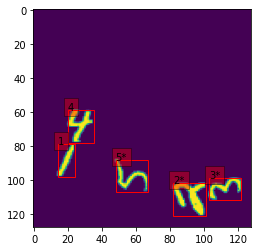

In [12]:
TRAIN_CANVAS_SIZE = 2000
TRAIN_SEED = 42 # DO NOT CHANGE THIS LINE.

np.random.seed(TRAIN_SEED)

TRAIN_CANVAS = [
    get_random_canvas(
        digits=TRAIN_DIGITS,
        classes=TRAIN_CLASSES,
    )
    for _ in range(TRAIN_CANVAS_SIZE)
]

TRAIN_CANVAS[0].plot()

--------------------- Starting training ---------------------
----- Epoch 1 -----
[Epoch: 1, Batch: 50]		Loss: 3.968
[Epoch: 1, Batch: 100]		Loss: 3.603
[Epoch: 1, Batch: 150]		Loss: 3.055
[Epoch: 1, Batch: 200]		Loss: 2.705
[Epoch: 1, Batch: 250]		Loss: 2.512
[Epoch: 1, Batch: 300]		Loss: 2.371
[Epoch: 1, Batch: 350]		Loss: 2.249
[Epoch: 1, Batch: 400]		Loss: 2.158
[Epoch: 1, Batch: 450]		Loss: 2.080
[Epoch: 1, Batch: 500]		Loss: 2.016
[Epoch: 1, Batch: 550]		Loss: 1.956
[Epoch: 1, Batch: 600]		Loss: 1.902
[Epoch: 1, Batch: 650]		Loss: 1.859
[Epoch: 1, Batch: 700]		Loss: 1.818
[Epoch: 1, Batch: 750]		Loss: 1.781
[Epoch: 1, Batch: 800]		Loss: 1.751
[Epoch: 1, Batch: 850]		Loss: 1.716
[Epoch: 1, Batch: 900]		Loss: 1.689
[Epoch: 1, Batch: 950]		Loss: 1.663
[Epoch: 1, Batch: 1000]		Loss: 1.637
[Epoch: 1, Batch: 1050]		Loss: 1.610
[Epoch: 1, Batch: 1100]		Loss: 1.585
[Epoch: 1, Batch: 1150]		Loss: 1.562
[Epoch: 1, Batch: 1200]		Loss: 1.539
[Epoch: 1, Batch: 1250]		Loss: 1.523
[Epoch: 1, Ba

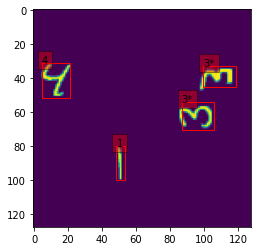

Incorrect predictions:


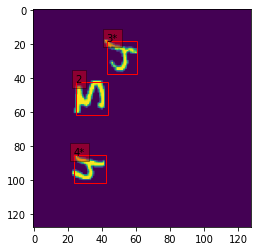

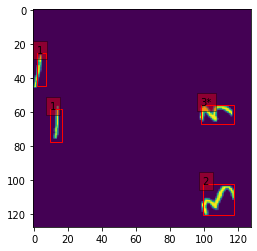

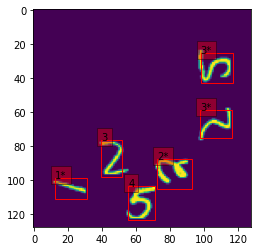

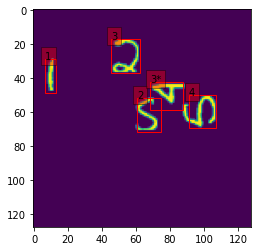

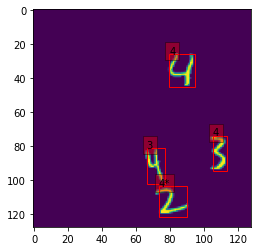

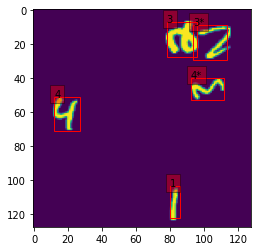

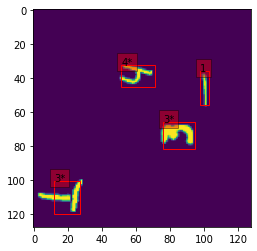

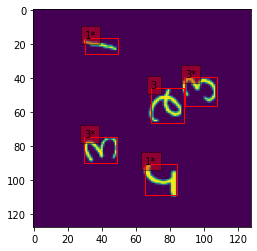

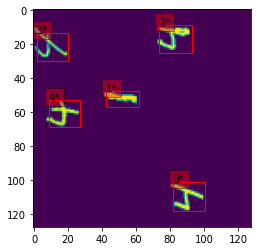

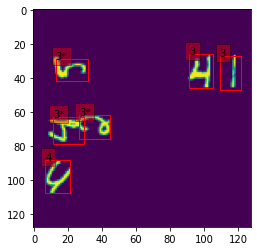

Loss: 0.870,	Acc: 1/256	[0.39%]
----- Epoch 2 -----
[Epoch: 2, Batch: 50]		Loss: 0.827
[Epoch: 2, Batch: 100]		Loss: 0.800
[Epoch: 2, Batch: 150]		Loss: 0.791
[Epoch: 2, Batch: 200]		Loss: 0.769
[Epoch: 2, Batch: 250]		Loss: 0.769
[Epoch: 2, Batch: 300]		Loss: 0.769
[Epoch: 2, Batch: 350]		Loss: 0.758
[Epoch: 2, Batch: 400]		Loss: 0.752
[Epoch: 2, Batch: 450]		Loss: 0.740
[Epoch: 2, Batch: 500]		Loss: 0.735
[Epoch: 2, Batch: 550]		Loss: 0.729
[Epoch: 2, Batch: 600]		Loss: 0.723
[Epoch: 2, Batch: 650]		Loss: 0.720
[Epoch: 2, Batch: 700]		Loss: 0.719
[Epoch: 2, Batch: 750]		Loss: 0.713
[Epoch: 2, Batch: 800]		Loss: 0.710
[Epoch: 2, Batch: 850]		Loss: 0.704
[Epoch: 2, Batch: 900]		Loss: 0.702
[Epoch: 2, Batch: 950]		Loss: 0.700
[Epoch: 2, Batch: 1000]		Loss: 0.697
[Epoch: 2, Batch: 1050]		Loss: 0.692
[Epoch: 2, Batch: 1100]		Loss: 0.687
[Epoch: 2, Batch: 1150]		Loss: 0.683
[Epoch: 2, Batch: 1200]		Loss: 0.680
[Epoch: 2, Batch: 1250]		Loss: 0.681
[Epoch: 2, Batch: 1300]		Loss: 0.676
[Epoch

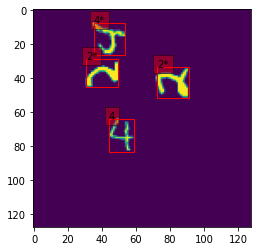

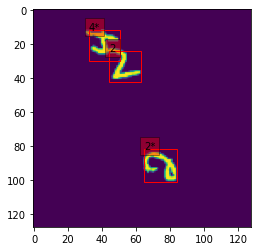

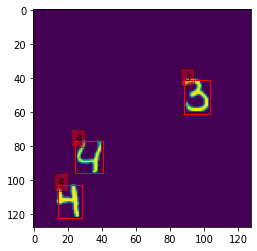

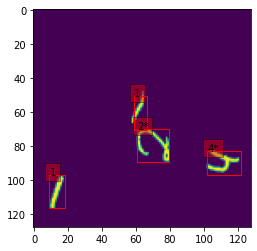

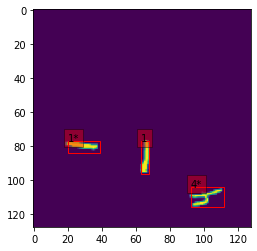

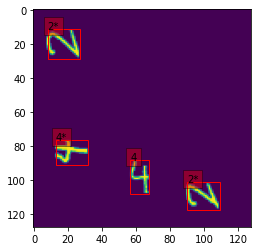

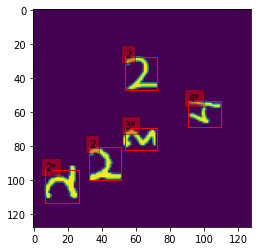

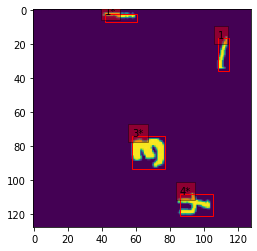

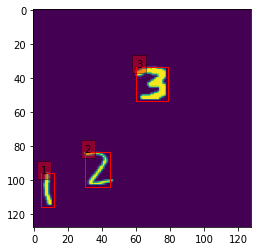

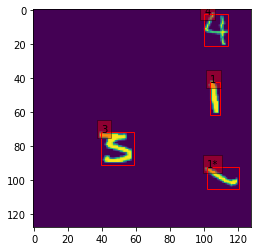

Incorrect predictions:


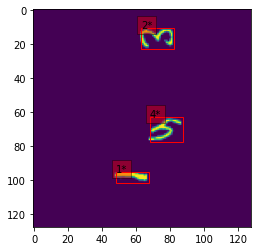

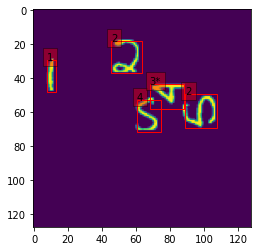

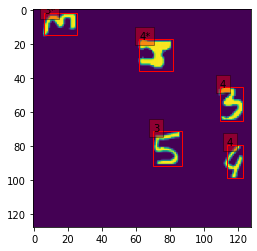

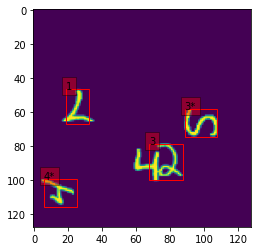

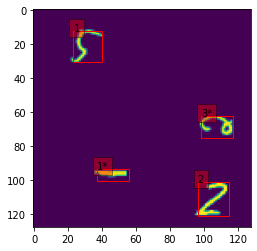

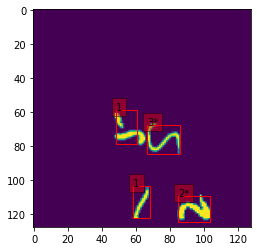

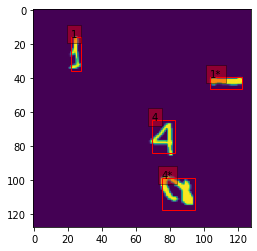

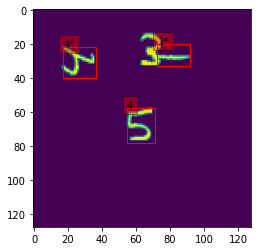

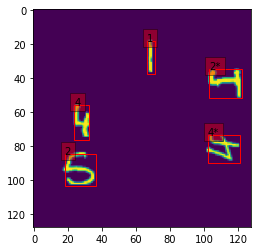

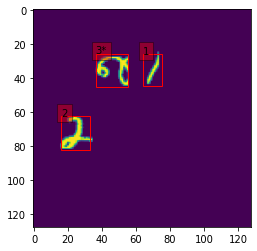

Loss: 0.599,	Acc: 11/256	[4.30%]
----- Epoch 3 -----
[Epoch: 3, Batch: 50]		Loss: 0.573
[Epoch: 3, Batch: 100]		Loss: 0.562
[Epoch: 3, Batch: 150]		Loss: 0.561
[Epoch: 3, Batch: 200]		Loss: 0.541
[Epoch: 3, Batch: 250]		Loss: 0.549
[Epoch: 3, Batch: 300]		Loss: 0.554
[Epoch: 3, Batch: 350]		Loss: 0.547
[Epoch: 3, Batch: 400]		Loss: 0.543
[Epoch: 3, Batch: 450]		Loss: 0.533
[Epoch: 3, Batch: 500]		Loss: 0.531
[Epoch: 3, Batch: 550]		Loss: 0.528
[Epoch: 3, Batch: 600]		Loss: 0.526
[Epoch: 3, Batch: 650]		Loss: 0.526
[Epoch: 3, Batch: 700]		Loss: 0.527
[Epoch: 3, Batch: 750]		Loss: 0.522
[Epoch: 3, Batch: 800]		Loss: 0.522
[Epoch: 3, Batch: 850]		Loss: 0.517
[Epoch: 3, Batch: 900]		Loss: 0.517
[Epoch: 3, Batch: 950]		Loss: 0.518
[Epoch: 3, Batch: 1000]		Loss: 0.517
[Epoch: 3, Batch: 1050]		Loss: 0.515
[Epoch: 3, Batch: 1100]		Loss: 0.511
[Epoch: 3, Batch: 1150]		Loss: 0.509
[Epoch: 3, Batch: 1200]		Loss: 0.508
[Epoch: 3, Batch: 1250]		Loss: 0.509
[Epoch: 3, Batch: 1300]		Loss: 0.506
[Epoc

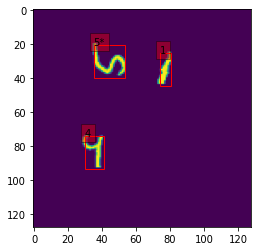

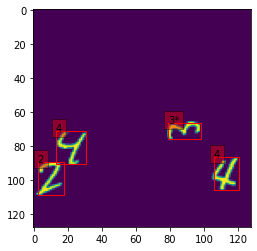

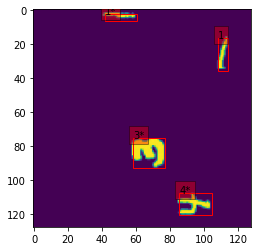

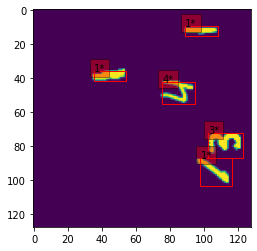

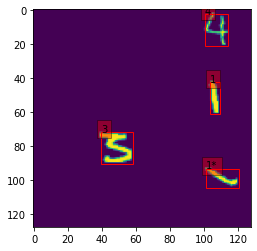

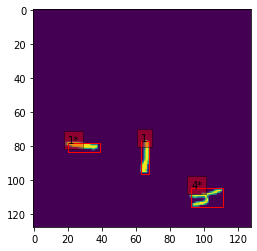

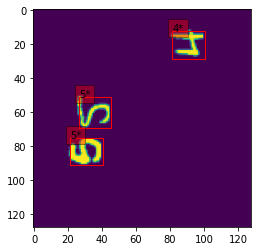

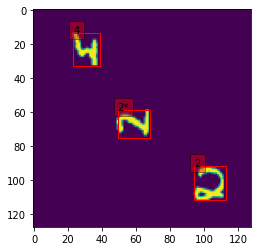

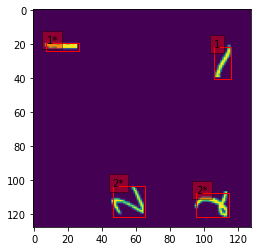

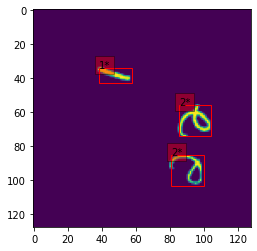

Incorrect predictions:


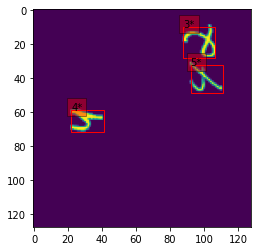

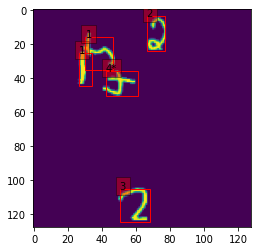

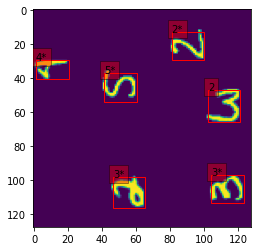

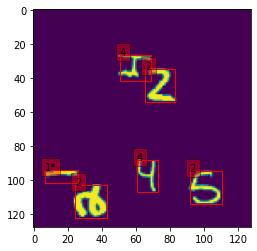

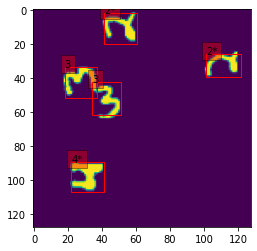

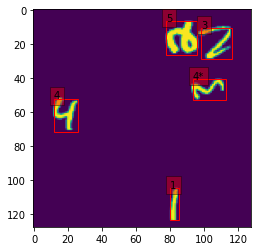

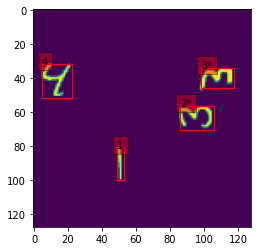

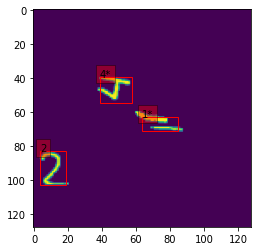

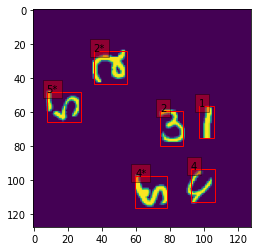

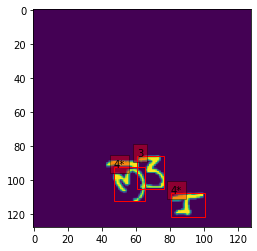

Loss: 0.463,	Acc: 24/256	[9.38%]
----- Epoch 4 -----
[Epoch: 4, Batch: 50]		Loss: 0.457
[Epoch: 4, Batch: 100]		Loss: 0.455
[Epoch: 4, Batch: 150]		Loss: 0.456
[Epoch: 4, Batch: 200]		Loss: 0.438
[Epoch: 4, Batch: 250]		Loss: 0.447
[Epoch: 4, Batch: 300]		Loss: 0.452
[Epoch: 4, Batch: 350]		Loss: 0.445
[Epoch: 4, Batch: 400]		Loss: 0.442
[Epoch: 4, Batch: 450]		Loss: 0.433
[Epoch: 4, Batch: 500]		Loss: 0.433
[Epoch: 4, Batch: 550]		Loss: 0.430
[Epoch: 4, Batch: 600]		Loss: 0.430
[Epoch: 4, Batch: 650]		Loss: 0.431
[Epoch: 4, Batch: 700]		Loss: 0.432
[Epoch: 4, Batch: 750]		Loss: 0.427
[Epoch: 4, Batch: 800]		Loss: 0.429
[Epoch: 4, Batch: 850]		Loss: 0.424
[Epoch: 4, Batch: 900]		Loss: 0.423
[Epoch: 4, Batch: 950]		Loss: 0.425
[Epoch: 4, Batch: 1000]		Loss: 0.424
[Epoch: 4, Batch: 1050]		Loss: 0.423
[Epoch: 4, Batch: 1100]		Loss: 0.419
[Epoch: 4, Batch: 1150]		Loss: 0.417
[Epoch: 4, Batch: 1200]		Loss: 0.416
[Epoch: 4, Batch: 1250]		Loss: 0.418
[Epoch: 4, Batch: 1300]		Loss: 0.416
[Epoc

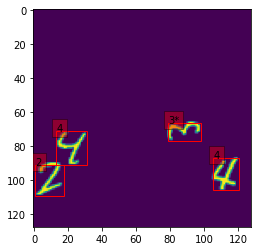

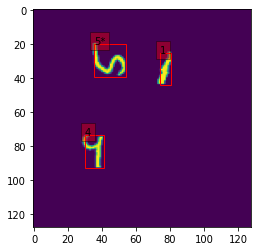

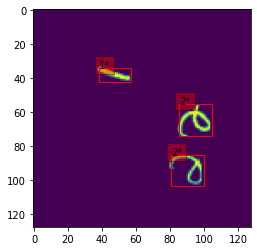

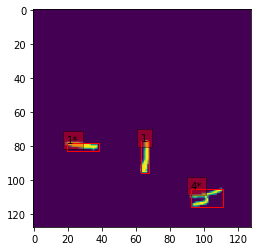

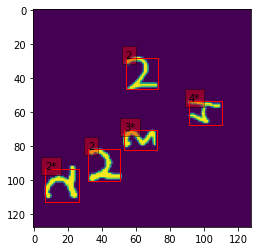

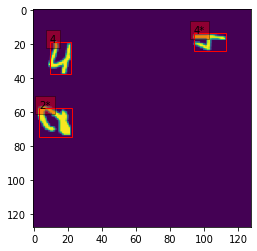

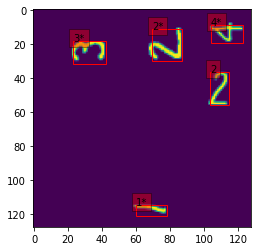

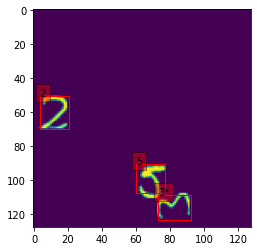

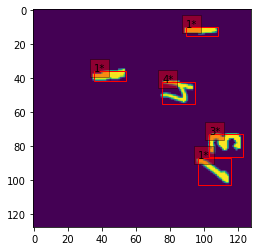

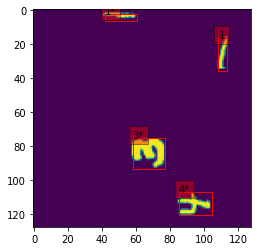

Incorrect predictions:


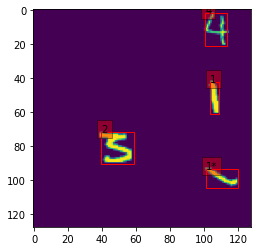

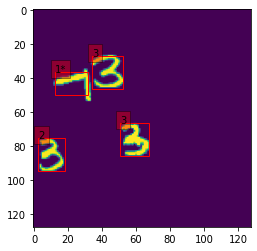

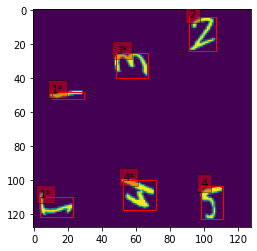

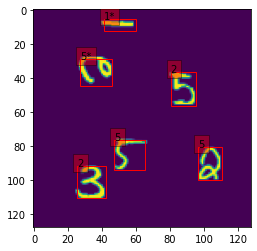

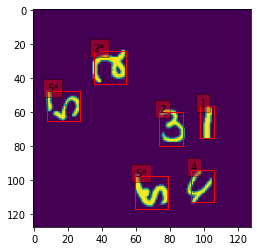

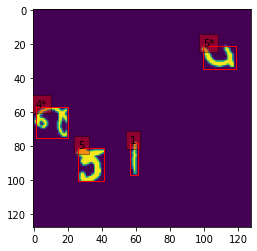

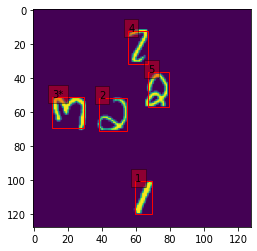

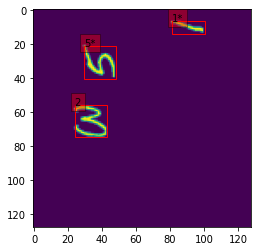

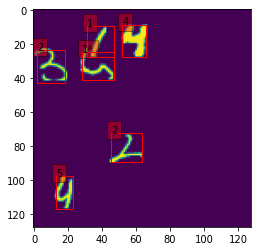

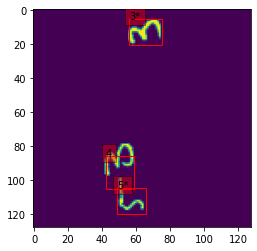

Loss: 0.378,	Acc: 42/256	[16.41%]
----- Epoch 5 -----
[Epoch: 5, Batch: 50]		Loss: 0.392
[Epoch: 5, Batch: 100]		Loss: 0.388
[Epoch: 5, Batch: 150]		Loss: 0.390
[Epoch: 5, Batch: 200]		Loss: 0.374
[Epoch: 5, Batch: 250]		Loss: 0.383
[Epoch: 5, Batch: 300]		Loss: 0.388
[Epoch: 5, Batch: 350]		Loss: 0.383
[Epoch: 5, Batch: 400]		Loss: 0.380
[Epoch: 5, Batch: 450]		Loss: 0.371
[Epoch: 5, Batch: 500]		Loss: 0.371
[Epoch: 5, Batch: 550]		Loss: 0.369
[Epoch: 5, Batch: 600]		Loss: 0.370
[Epoch: 5, Batch: 650]		Loss: 0.371
[Epoch: 5, Batch: 700]		Loss: 0.371
[Epoch: 5, Batch: 750]		Loss: 0.367
[Epoch: 5, Batch: 800]		Loss: 0.369
[Epoch: 5, Batch: 850]		Loss: 0.364
[Epoch: 5, Batch: 900]		Loss: 0.363
[Epoch: 5, Batch: 950]		Loss: 0.365
[Epoch: 5, Batch: 1000]		Loss: 0.365
[Epoch: 5, Batch: 1050]		Loss: 0.364
[Epoch: 5, Batch: 1100]		Loss: 0.360
[Epoch: 5, Batch: 1150]		Loss: 0.359
[Epoch: 5, Batch: 1200]		Loss: 0.358
[Epoch: 5, Batch: 1250]		Loss: 0.359
[Epoch: 5, Batch: 1300]		Loss: 0.357
[Epo

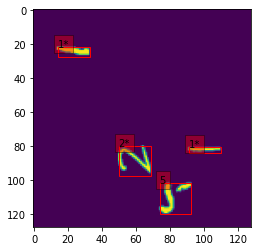

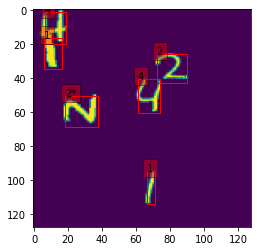

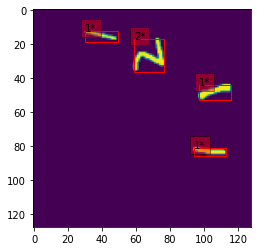

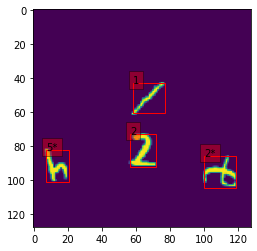

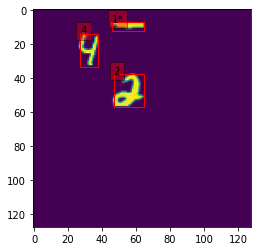

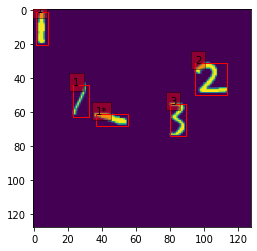

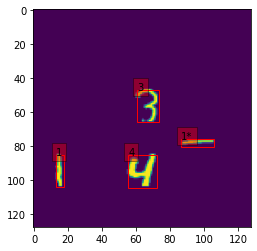

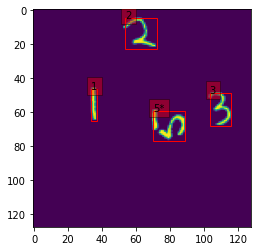

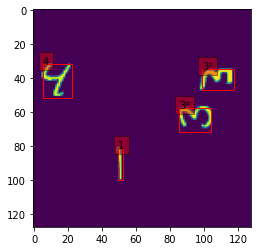

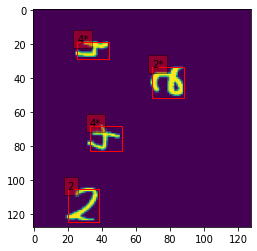

Incorrect predictions:


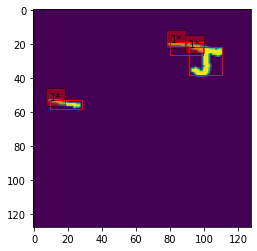

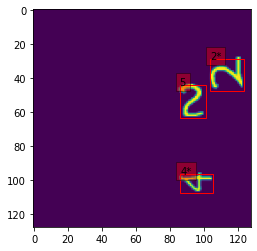

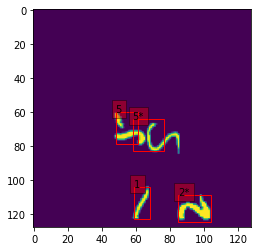

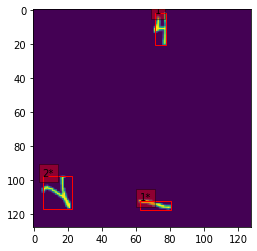

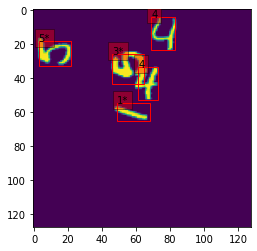

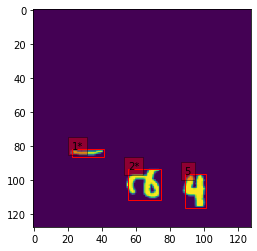

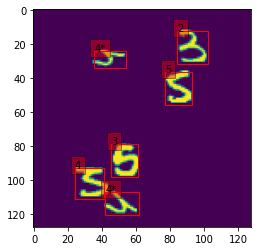

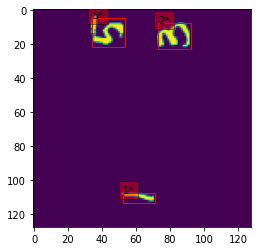

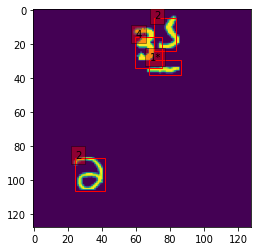

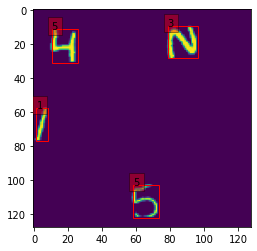

Loss: 0.342,	Acc: 55/256	[21.48%]
----- Epoch 6 -----
[Epoch: 6, Batch: 50]		Loss: 0.350
[Epoch: 6, Batch: 100]		Loss: 0.345
[Epoch: 6, Batch: 150]		Loss: 0.347
[Epoch: 6, Batch: 200]		Loss: 0.333
[Epoch: 6, Batch: 250]		Loss: 0.340
[Epoch: 6, Batch: 300]		Loss: 0.345
[Epoch: 6, Batch: 350]		Loss: 0.342
[Epoch: 6, Batch: 400]		Loss: 0.338
[Epoch: 6, Batch: 450]		Loss: 0.329
[Epoch: 6, Batch: 500]		Loss: 0.329
[Epoch: 6, Batch: 550]		Loss: 0.328
[Epoch: 6, Batch: 600]		Loss: 0.328
[Epoch: 6, Batch: 650]		Loss: 0.330
[Epoch: 6, Batch: 700]		Loss: 0.330
[Epoch: 6, Batch: 750]		Loss: 0.325
[Epoch: 6, Batch: 800]		Loss: 0.327
[Epoch: 6, Batch: 850]		Loss: 0.323
[Epoch: 6, Batch: 900]		Loss: 0.322
[Epoch: 6, Batch: 950]		Loss: 0.324
[Epoch: 6, Batch: 1000]		Loss: 0.324
[Epoch: 6, Batch: 1050]		Loss: 0.323
[Epoch: 6, Batch: 1100]		Loss: 0.319
[Epoch: 6, Batch: 1150]		Loss: 0.318
[Epoch: 6, Batch: 1200]		Loss: 0.317
[Epoch: 6, Batch: 1250]		Loss: 0.318
[Epoch: 6, Batch: 1300]		Loss: 0.317
[Epo

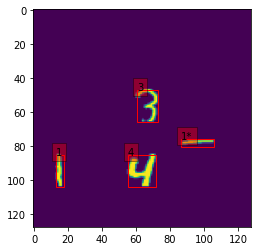

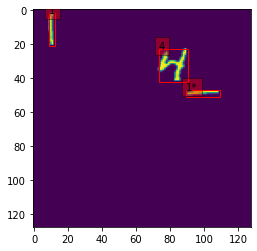

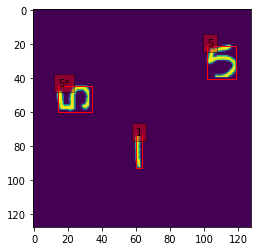

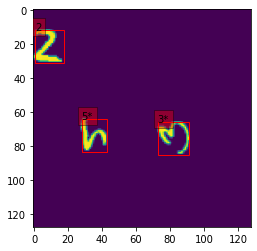

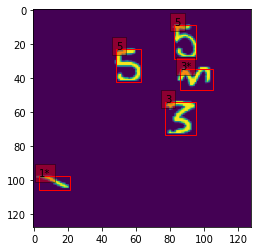

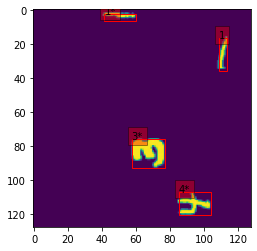

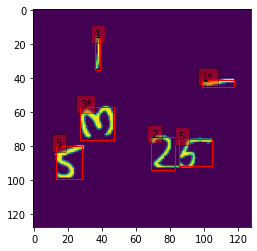

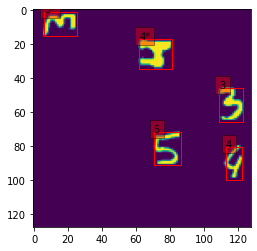

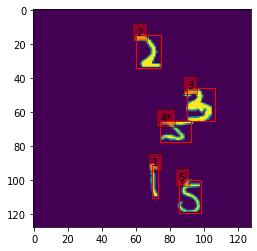

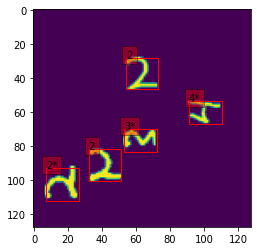

Incorrect predictions:


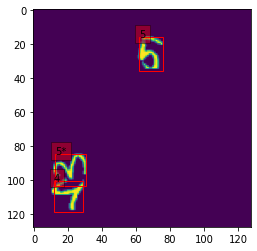

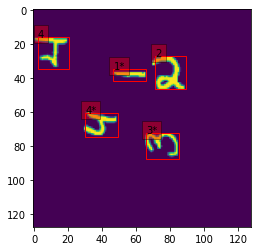

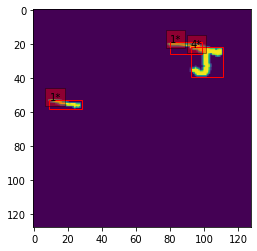

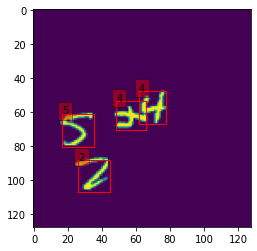

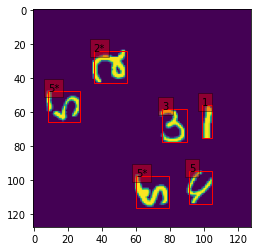

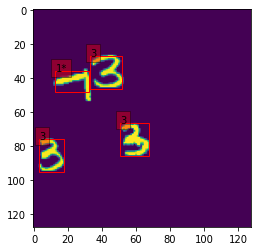

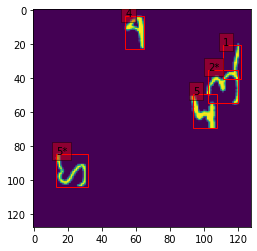

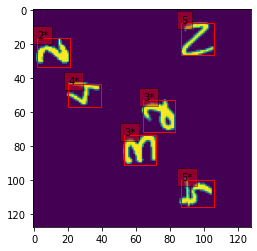

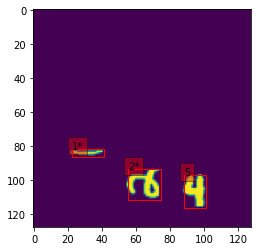

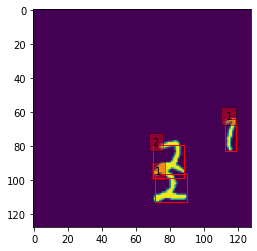

Loss: 0.320,	Acc: 76/256	[29.69%]
----- Epoch 7 -----
[Epoch: 7, Batch: 50]		Loss: 0.318
[Epoch: 7, Batch: 100]		Loss: 0.312
[Epoch: 7, Batch: 150]		Loss: 0.315
[Epoch: 7, Batch: 200]		Loss: 0.303
[Epoch: 7, Batch: 250]		Loss: 0.309
[Epoch: 7, Batch: 300]		Loss: 0.314
[Epoch: 7, Batch: 350]		Loss: 0.311
[Epoch: 7, Batch: 400]		Loss: 0.307
[Epoch: 7, Batch: 450]		Loss: 0.298
[Epoch: 7, Batch: 500]		Loss: 0.298
[Epoch: 7, Batch: 550]		Loss: 0.296
[Epoch: 7, Batch: 600]		Loss: 0.297
[Epoch: 7, Batch: 650]		Loss: 0.298
[Epoch: 7, Batch: 700]		Loss: 0.298
[Epoch: 7, Batch: 750]		Loss: 0.293
[Epoch: 7, Batch: 800]		Loss: 0.296
[Epoch: 7, Batch: 850]		Loss: 0.292
[Epoch: 7, Batch: 900]		Loss: 0.290
[Epoch: 7, Batch: 950]		Loss: 0.292
[Epoch: 7, Batch: 1000]		Loss: 0.292
[Epoch: 7, Batch: 1050]		Loss: 0.291
[Epoch: 7, Batch: 1100]		Loss: 0.288
[Epoch: 7, Batch: 1150]		Loss: 0.287
[Epoch: 7, Batch: 1200]		Loss: 0.286
[Epoch: 7, Batch: 1250]		Loss: 0.287
[Epoch: 7, Batch: 1300]		Loss: 0.286
[Epo

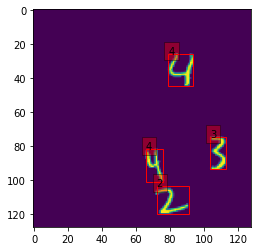

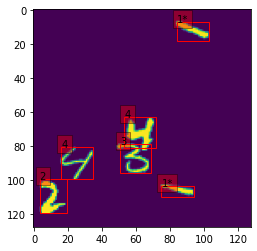

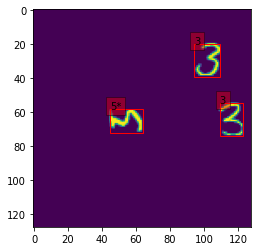

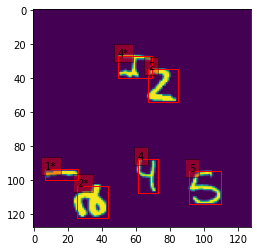

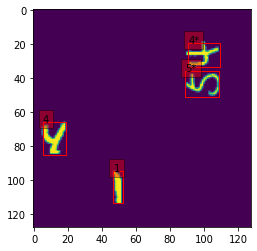

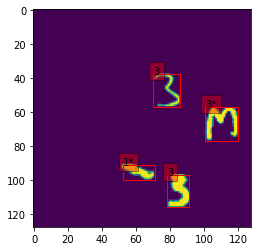

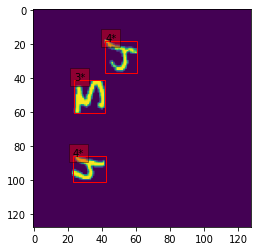

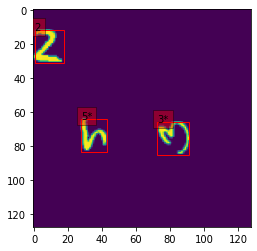

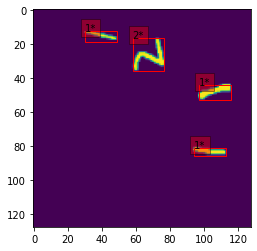

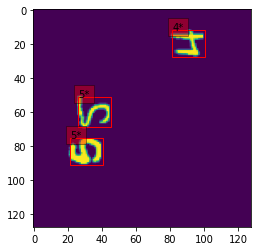

Incorrect predictions:


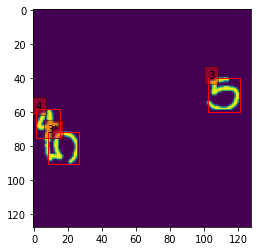

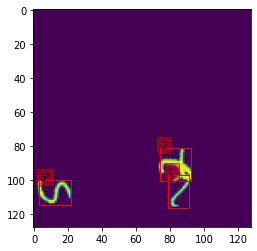

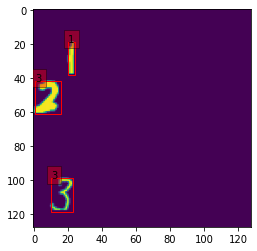

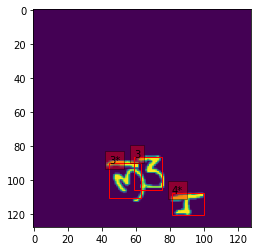

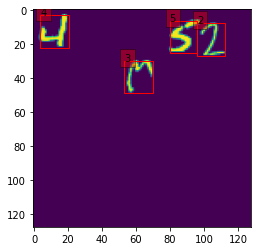

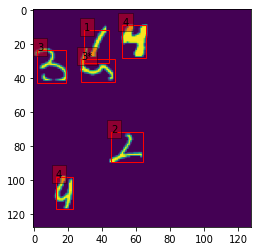

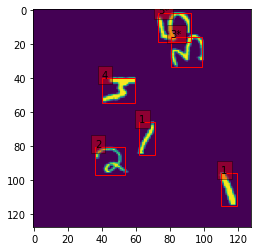

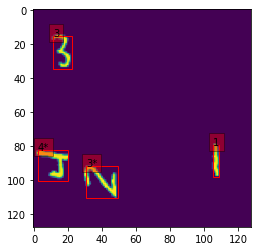

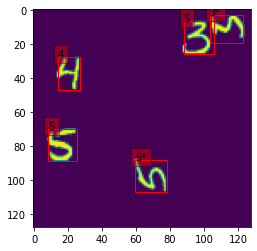

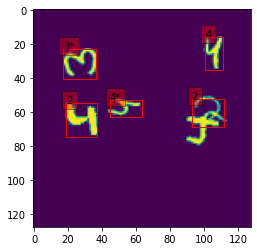

Loss: 0.300,	Acc: 91/256	[35.55%]
----- Epoch 8 -----
[Epoch: 8, Batch: 50]		Loss: 0.293
[Epoch: 8, Batch: 100]		Loss: 0.287
[Epoch: 8, Batch: 150]		Loss: 0.289
[Epoch: 8, Batch: 200]		Loss: 0.278
[Epoch: 8, Batch: 250]		Loss: 0.284
[Epoch: 8, Batch: 300]		Loss: 0.288
[Epoch: 8, Batch: 350]		Loss: 0.285
[Epoch: 8, Batch: 400]		Loss: 0.281
[Epoch: 8, Batch: 450]		Loss: 0.272
[Epoch: 8, Batch: 500]		Loss: 0.272
[Epoch: 8, Batch: 550]		Loss: 0.271
[Epoch: 8, Batch: 600]		Loss: 0.271
[Epoch: 8, Batch: 650]		Loss: 0.272
[Epoch: 8, Batch: 700]		Loss: 0.272
[Epoch: 8, Batch: 750]		Loss: 0.267
[Epoch: 8, Batch: 800]		Loss: 0.270
[Epoch: 8, Batch: 850]		Loss: 0.266
[Epoch: 8, Batch: 900]		Loss: 0.265
[Epoch: 8, Batch: 950]		Loss: 0.266
[Epoch: 8, Batch: 1000]		Loss: 0.266
[Epoch: 8, Batch: 1050]		Loss: 0.266
[Epoch: 8, Batch: 1100]		Loss: 0.263
[Epoch: 8, Batch: 1150]		Loss: 0.262
[Epoch: 8, Batch: 1200]		Loss: 0.261
[Epoch: 8, Batch: 1250]		Loss: 0.261
[Epoch: 8, Batch: 1300]		Loss: 0.260
[Epo

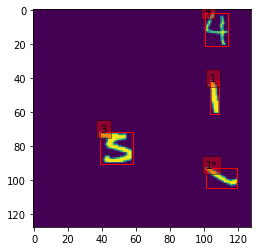

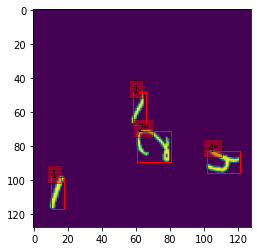

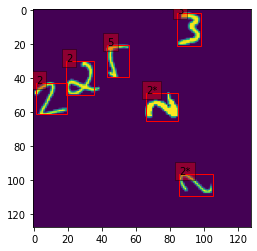

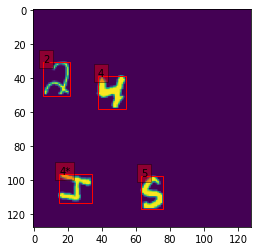

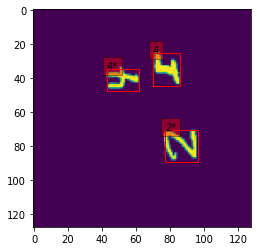

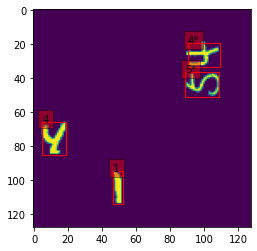

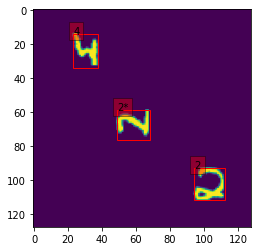

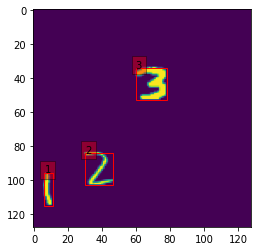

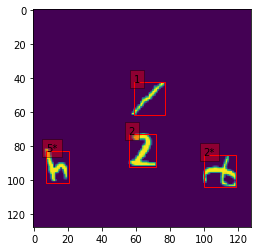

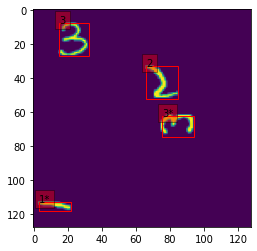

Incorrect predictions:


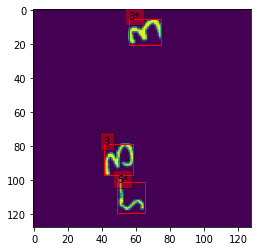

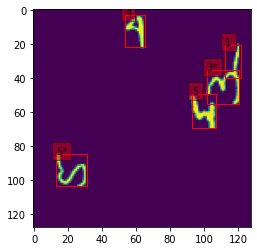

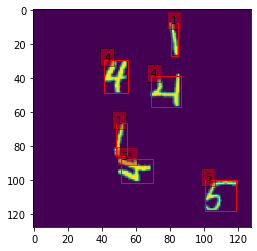

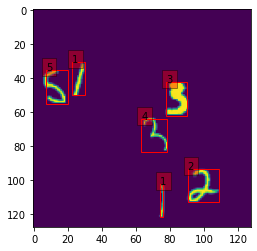

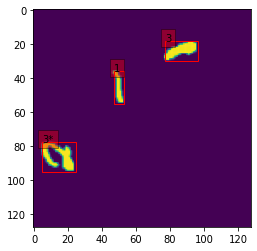

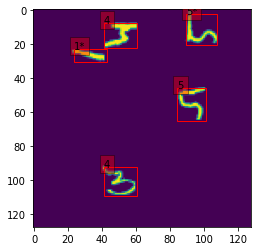

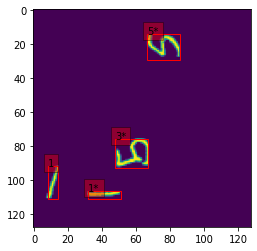

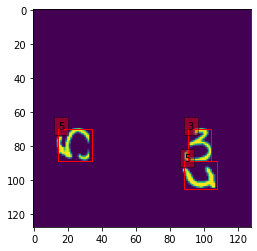

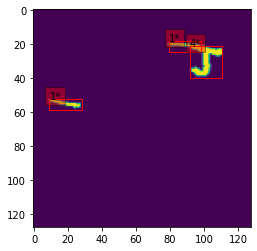

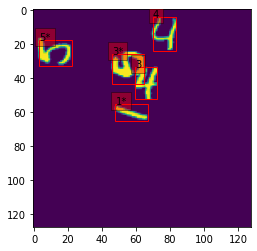

Loss: 0.285,	Acc: 108/256	[42.19%]
----- Epoch 9 -----
[Epoch: 9, Batch: 50]		Loss: 0.270
[Epoch: 9, Batch: 100]		Loss: 0.264
[Epoch: 9, Batch: 150]		Loss: 0.267
[Epoch: 9, Batch: 200]		Loss: 0.256
[Epoch: 9, Batch: 250]		Loss: 0.263
[Epoch: 9, Batch: 300]		Loss: 0.265
[Epoch: 9, Batch: 350]		Loss: 0.262
[Epoch: 9, Batch: 400]		Loss: 0.258
[Epoch: 9, Batch: 450]		Loss: 0.250
[Epoch: 9, Batch: 500]		Loss: 0.250
[Epoch: 9, Batch: 550]		Loss: 0.249
[Epoch: 9, Batch: 600]		Loss: 0.249
[Epoch: 9, Batch: 650]		Loss: 0.250
[Epoch: 9, Batch: 700]		Loss: 0.250
[Epoch: 9, Batch: 750]		Loss: 0.245
[Epoch: 9, Batch: 800]		Loss: 0.248
[Epoch: 9, Batch: 850]		Loss: 0.244
[Epoch: 9, Batch: 900]		Loss: 0.243
[Epoch: 9, Batch: 950]		Loss: 0.244
[Epoch: 9, Batch: 1000]		Loss: 0.244
[Epoch: 9, Batch: 1050]		Loss: 0.244
[Epoch: 9, Batch: 1100]		Loss: 0.241
[Epoch: 9, Batch: 1150]		Loss: 0.240
[Epoch: 9, Batch: 1200]		Loss: 0.239
[Epoch: 9, Batch: 1250]		Loss: 0.239
[Epoch: 9, Batch: 1300]		Loss: 0.238
[Ep

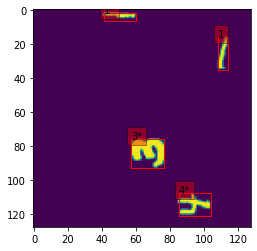

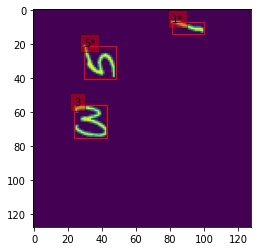

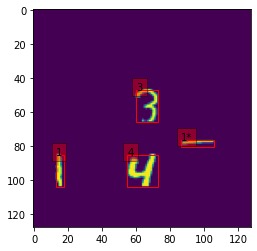

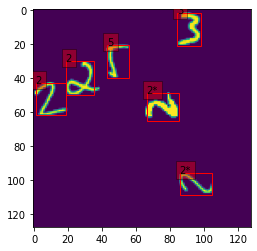

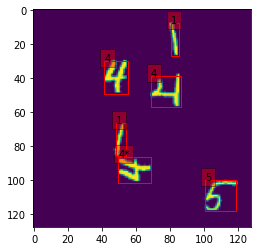

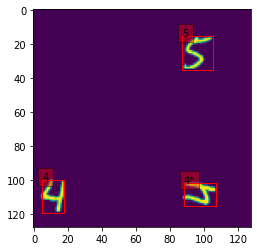

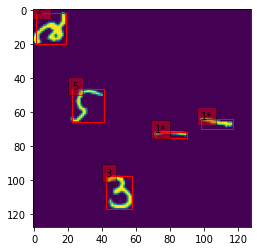

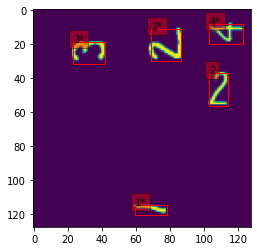

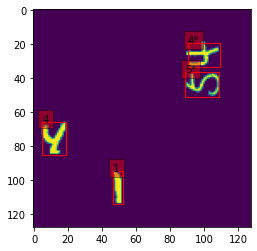

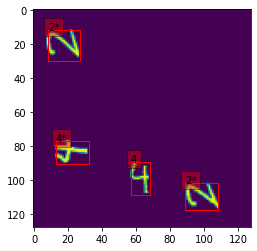

Incorrect predictions:


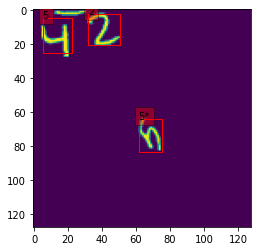

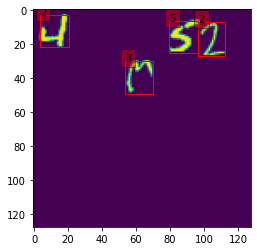

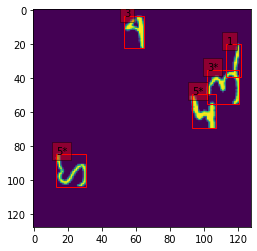

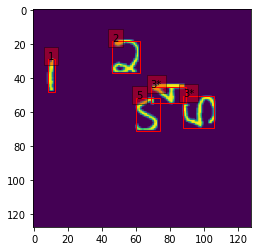

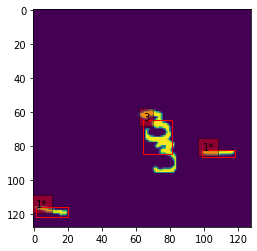

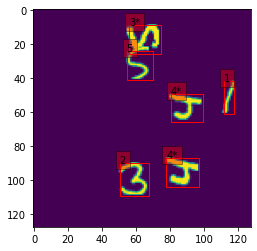

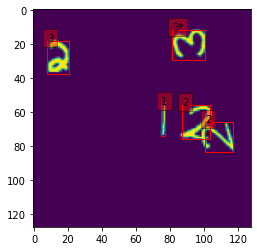

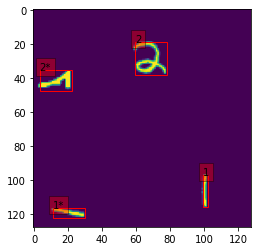

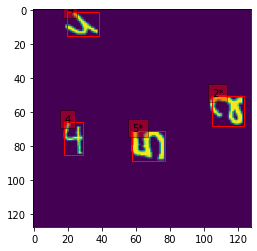

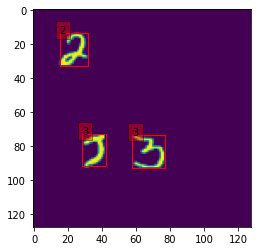

Loss: 0.268,	Acc: 116/256	[45.31%]
----- Epoch 10 -----
[Epoch: 10, Batch: 50]		Loss: 0.251
[Epoch: 10, Batch: 100]		Loss: 0.244
[Epoch: 10, Batch: 150]		Loss: 0.247
[Epoch: 10, Batch: 200]		Loss: 0.237
[Epoch: 10, Batch: 250]		Loss: 0.243
[Epoch: 10, Batch: 300]		Loss: 0.245
[Epoch: 10, Batch: 350]		Loss: 0.243
[Epoch: 10, Batch: 400]		Loss: 0.239
[Epoch: 10, Batch: 450]		Loss: 0.232
[Epoch: 10, Batch: 500]		Loss: 0.231
[Epoch: 10, Batch: 550]		Loss: 0.230
[Epoch: 10, Batch: 600]		Loss: 0.230
[Epoch: 10, Batch: 650]		Loss: 0.231
[Epoch: 10, Batch: 700]		Loss: 0.230
[Epoch: 10, Batch: 750]		Loss: 0.227
[Epoch: 10, Batch: 800]		Loss: 0.229
[Epoch: 10, Batch: 850]		Loss: 0.225
[Epoch: 10, Batch: 900]		Loss: 0.224
[Epoch: 10, Batch: 950]		Loss: 0.225
[Epoch: 10, Batch: 1000]		Loss: 0.225
[Epoch: 10, Batch: 1050]		Loss: 0.225
[Epoch: 10, Batch: 1100]		Loss: 0.222
[Epoch: 10, Batch: 1150]		Loss: 0.221
[Epoch: 10, Batch: 1200]		Loss: 0.220
[Epoch: 10, Batch: 1250]		Loss: 0.220
[Epoch: 10, Ba

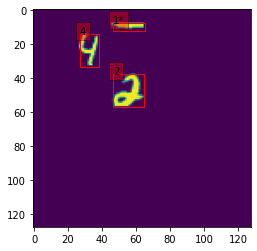

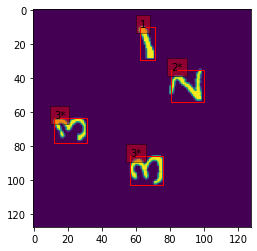

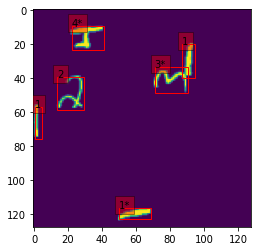

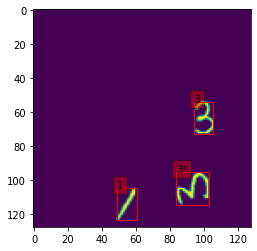

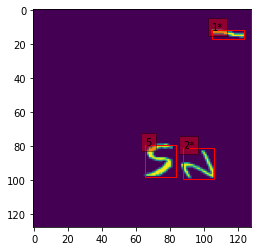

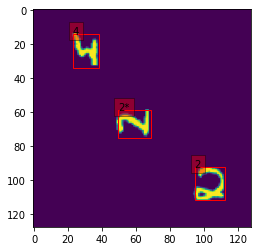

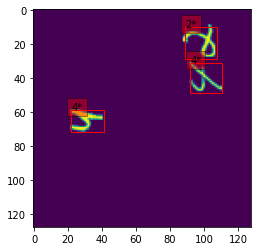

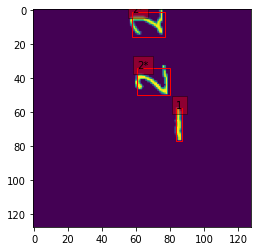

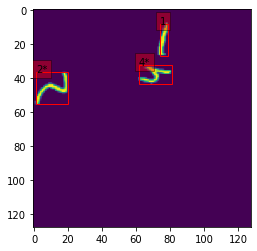

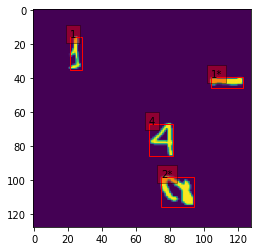

Incorrect predictions:


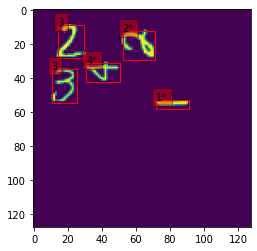

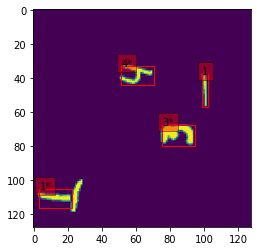

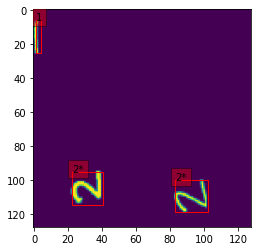

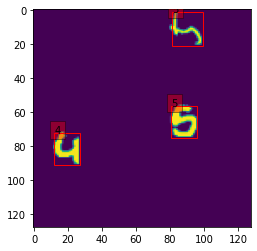

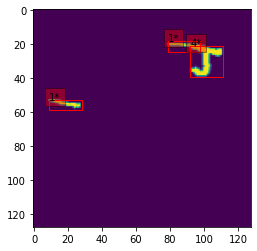

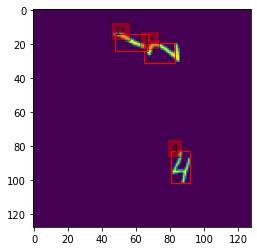

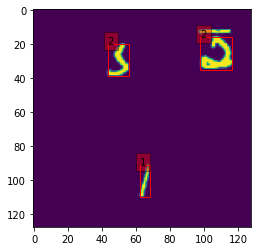

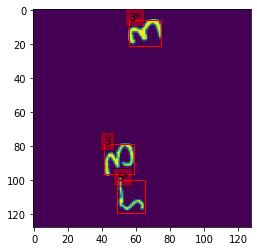

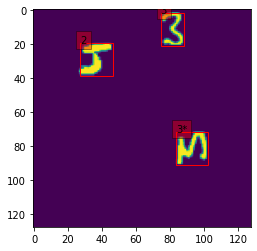

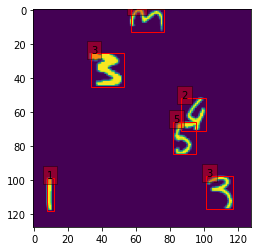

Loss: 0.258,	Acc: 135/256	[52.73%]
----- Epoch 11 -----
[Epoch: 11, Batch: 50]		Loss: 0.235
[Epoch: 11, Batch: 100]		Loss: 0.227
[Epoch: 11, Batch: 150]		Loss: 0.230
[Epoch: 11, Batch: 200]		Loss: 0.221
[Epoch: 11, Batch: 250]		Loss: 0.226
[Epoch: 11, Batch: 300]		Loss: 0.228
[Epoch: 11, Batch: 350]		Loss: 0.226
[Epoch: 11, Batch: 400]		Loss: 0.222
[Epoch: 11, Batch: 450]		Loss: 0.215
[Epoch: 11, Batch: 500]		Loss: 0.214
[Epoch: 11, Batch: 550]		Loss: 0.213
[Epoch: 11, Batch: 600]		Loss: 0.213
[Epoch: 11, Batch: 650]		Loss: 0.214
[Epoch: 11, Batch: 700]		Loss: 0.214
[Epoch: 11, Batch: 750]		Loss: 0.210
[Epoch: 11, Batch: 800]		Loss: 0.212
[Epoch: 11, Batch: 850]		Loss: 0.209
[Epoch: 11, Batch: 900]		Loss: 0.208
[Epoch: 11, Batch: 950]		Loss: 0.209
[Epoch: 11, Batch: 1000]		Loss: 0.209
[Epoch: 11, Batch: 1050]		Loss: 0.208
[Epoch: 11, Batch: 1100]		Loss: 0.206
[Epoch: 11, Batch: 1150]		Loss: 0.205
[Epoch: 11, Batch: 1200]		Loss: 0.204
[Epoch: 11, Batch: 1250]		Loss: 0.204
[Epoch: 11, Ba

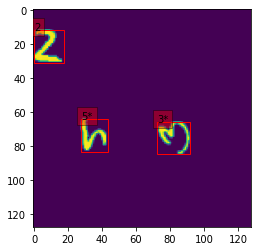

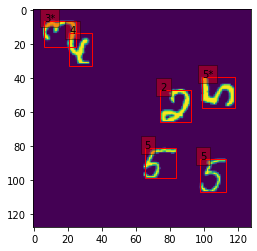

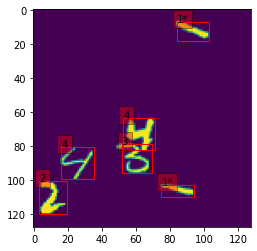

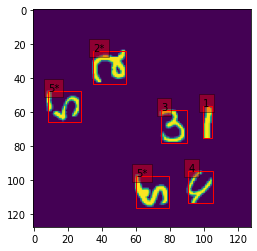

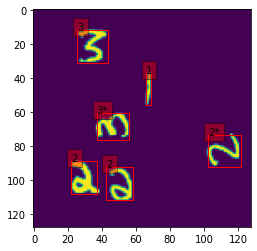

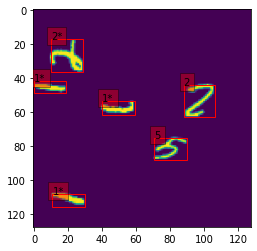

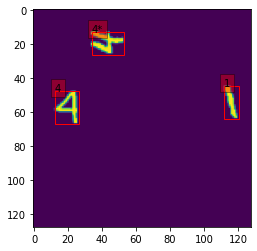

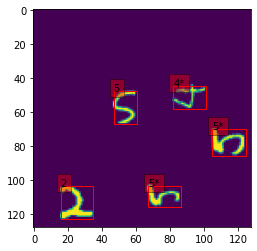

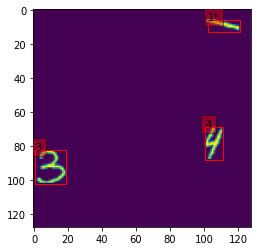

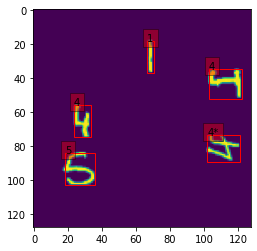

Incorrect predictions:


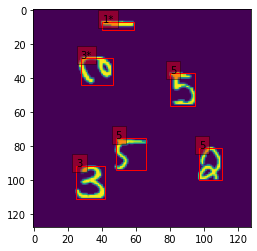

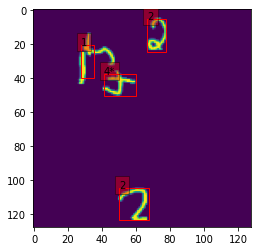

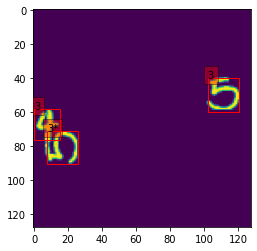

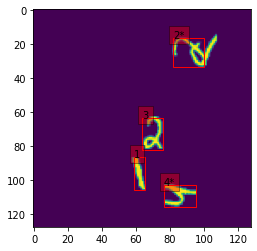

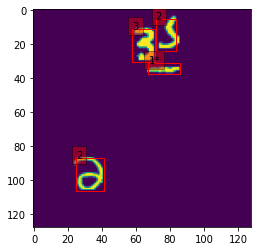

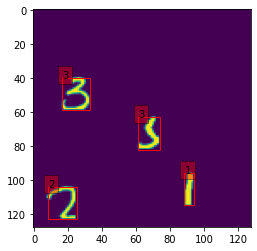

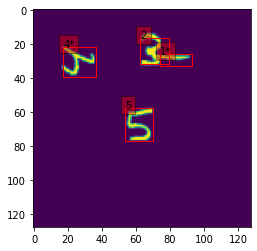

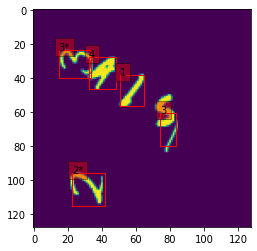

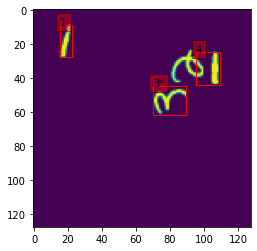

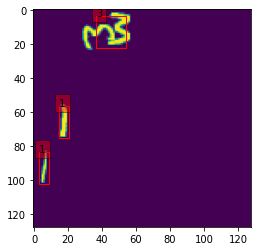

Loss: 0.248,	Acc: 141/256	[55.08%]
----- Epoch 12 -----
[Epoch: 12, Batch: 50]		Loss: 0.220
[Epoch: 12, Batch: 100]		Loss: 0.210
[Epoch: 12, Batch: 150]		Loss: 0.214
[Epoch: 12, Batch: 200]		Loss: 0.206
[Epoch: 12, Batch: 250]		Loss: 0.212
[Epoch: 12, Batch: 300]		Loss: 0.213
[Epoch: 12, Batch: 350]		Loss: 0.211
[Epoch: 12, Batch: 400]		Loss: 0.207
[Epoch: 12, Batch: 450]		Loss: 0.201
[Epoch: 12, Batch: 500]		Loss: 0.200
[Epoch: 12, Batch: 550]		Loss: 0.199
[Epoch: 12, Batch: 600]		Loss: 0.198
[Epoch: 12, Batch: 650]		Loss: 0.199
[Epoch: 12, Batch: 700]		Loss: 0.199
[Epoch: 12, Batch: 750]		Loss: 0.196
[Epoch: 12, Batch: 800]		Loss: 0.198
[Epoch: 12, Batch: 850]		Loss: 0.194
[Epoch: 12, Batch: 900]		Loss: 0.193
[Epoch: 12, Batch: 950]		Loss: 0.194
[Epoch: 12, Batch: 1000]		Loss: 0.194
[Epoch: 12, Batch: 1050]		Loss: 0.194
[Epoch: 12, Batch: 1100]		Loss: 0.191
[Epoch: 12, Batch: 1150]		Loss: 0.191
[Epoch: 12, Batch: 1200]		Loss: 0.190
[Epoch: 12, Batch: 1250]		Loss: 0.189
[Epoch: 12, Ba

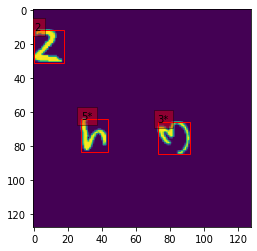

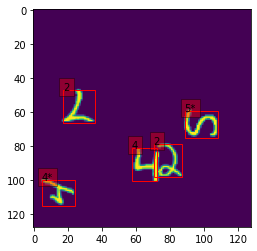

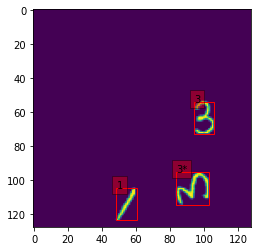

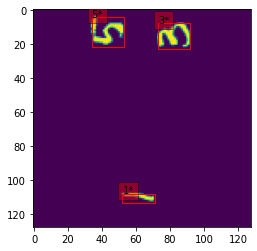

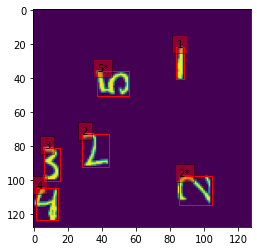

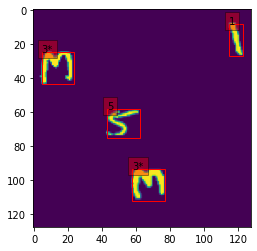

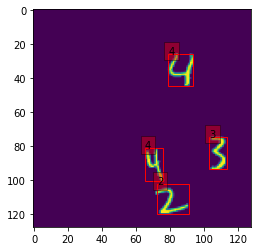

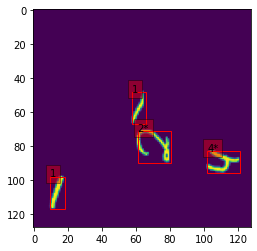

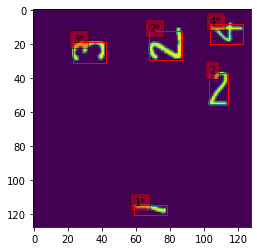

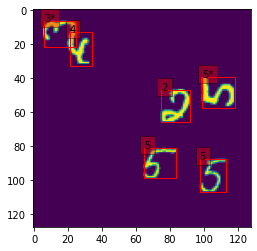

Incorrect predictions:


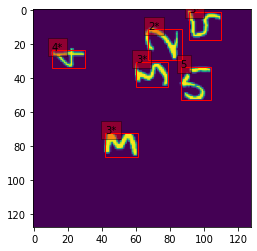

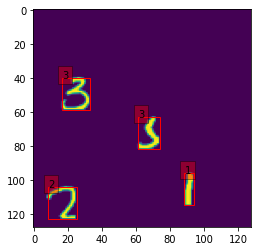

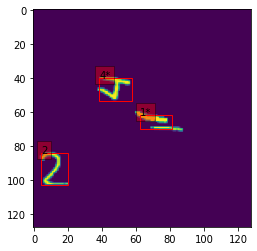

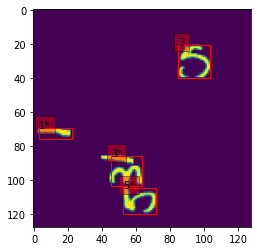

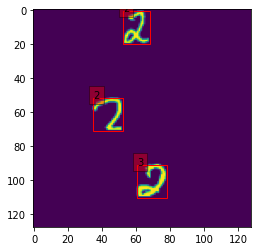

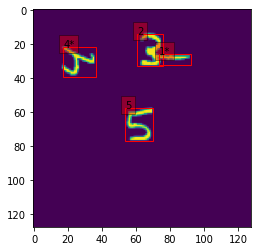

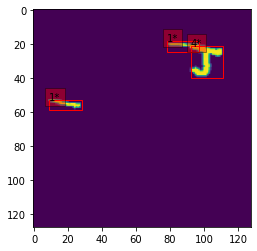

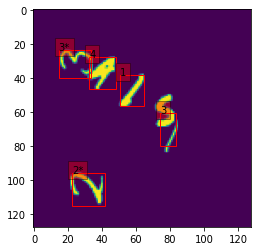

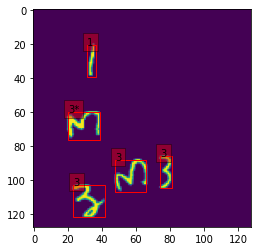

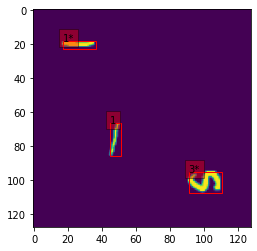

Loss: 0.241,	Acc: 141/256	[55.08%]
----- Epoch 13 -----
[Epoch: 13, Batch: 50]		Loss: 0.208
[Epoch: 13, Batch: 100]		Loss: 0.197
[Epoch: 13, Batch: 150]		Loss: 0.201
[Epoch: 13, Batch: 200]		Loss: 0.193
[Epoch: 13, Batch: 250]		Loss: 0.198
[Epoch: 13, Batch: 300]		Loss: 0.199
[Epoch: 13, Batch: 350]		Loss: 0.198
[Epoch: 13, Batch: 400]		Loss: 0.195
[Epoch: 13, Batch: 450]		Loss: 0.189
[Epoch: 13, Batch: 500]		Loss: 0.187
[Epoch: 13, Batch: 550]		Loss: 0.186
[Epoch: 13, Batch: 600]		Loss: 0.186
[Epoch: 13, Batch: 650]		Loss: 0.187
[Epoch: 13, Batch: 700]		Loss: 0.187
[Epoch: 13, Batch: 750]		Loss: 0.183
[Epoch: 13, Batch: 800]		Loss: 0.185
[Epoch: 13, Batch: 850]		Loss: 0.182
[Epoch: 13, Batch: 900]		Loss: 0.181
[Epoch: 13, Batch: 950]		Loss: 0.182
[Epoch: 13, Batch: 1000]		Loss: 0.182
[Epoch: 13, Batch: 1050]		Loss: 0.181
[Epoch: 13, Batch: 1100]		Loss: 0.179
[Epoch: 13, Batch: 1150]		Loss: 0.178
[Epoch: 13, Batch: 1200]		Loss: 0.177
[Epoch: 13, Batch: 1250]		Loss: 0.177
[Epoch: 13, Ba

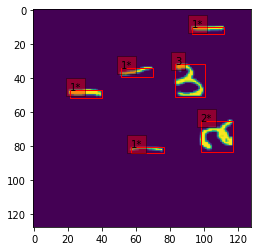

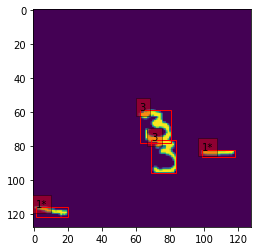

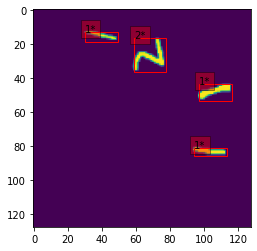

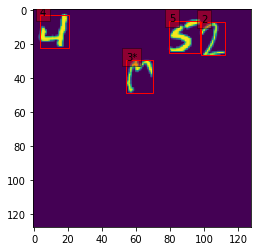

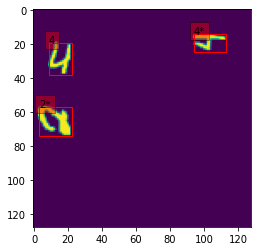

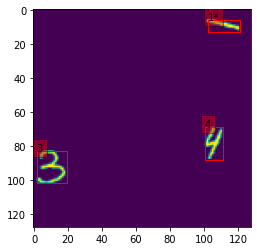

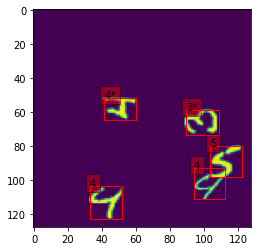

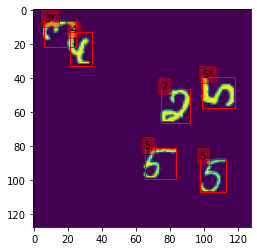

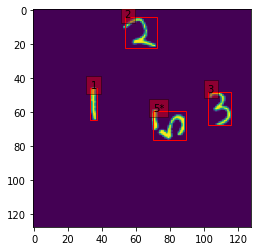

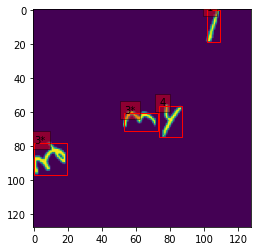

Incorrect predictions:


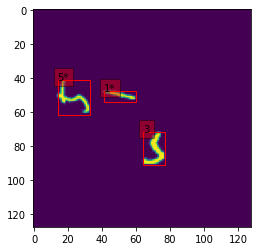

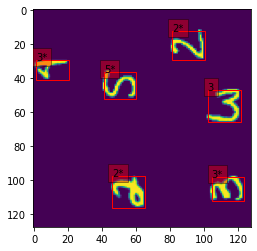

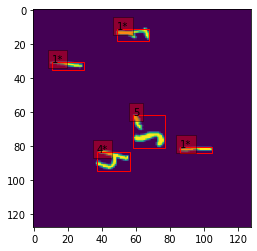

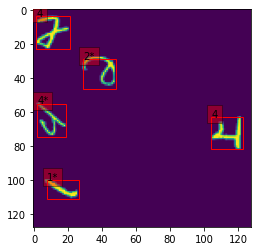

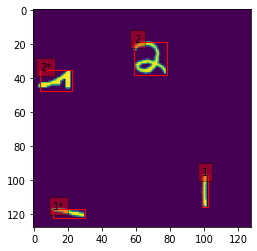

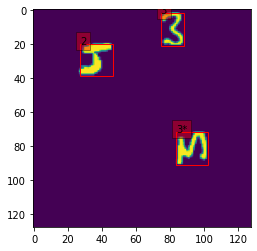

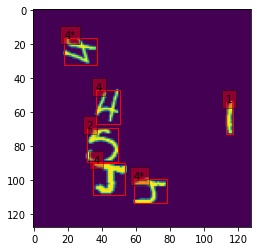

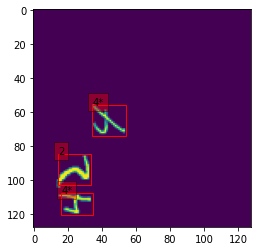

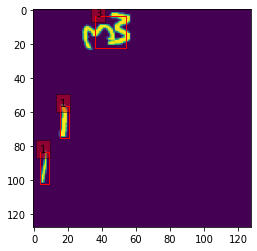

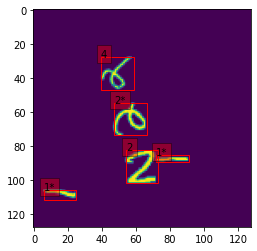

Loss: 0.230,	Acc: 161/256	[62.89%]
----- Epoch 14 -----
[Epoch: 14, Batch: 50]		Loss: 0.195
[Epoch: 14, Batch: 100]		Loss: 0.185
[Epoch: 14, Batch: 150]		Loss: 0.189
[Epoch: 14, Batch: 200]		Loss: 0.182
[Epoch: 14, Batch: 250]		Loss: 0.187
[Epoch: 14, Batch: 300]		Loss: 0.187
[Epoch: 14, Batch: 350]		Loss: 0.186
[Epoch: 14, Batch: 400]		Loss: 0.183
[Epoch: 14, Batch: 450]		Loss: 0.177
[Epoch: 14, Batch: 500]		Loss: 0.176
[Epoch: 14, Batch: 550]		Loss: 0.175
[Epoch: 14, Batch: 600]		Loss: 0.175
[Epoch: 14, Batch: 650]		Loss: 0.175
[Epoch: 14, Batch: 700]		Loss: 0.175
[Epoch: 14, Batch: 750]		Loss: 0.172
[Epoch: 14, Batch: 800]		Loss: 0.174
[Epoch: 14, Batch: 850]		Loss: 0.171
[Epoch: 14, Batch: 900]		Loss: 0.170
[Epoch: 14, Batch: 950]		Loss: 0.171
[Epoch: 14, Batch: 1000]		Loss: 0.171
[Epoch: 14, Batch: 1050]		Loss: 0.170
[Epoch: 14, Batch: 1100]		Loss: 0.168
[Epoch: 14, Batch: 1150]		Loss: 0.167
[Epoch: 14, Batch: 1200]		Loss: 0.166
[Epoch: 14, Batch: 1250]		Loss: 0.166
[Epoch: 14, Ba

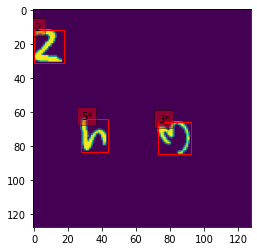

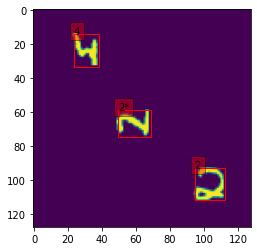

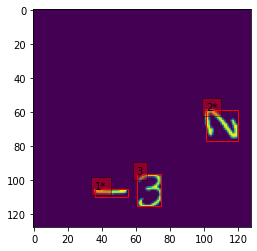

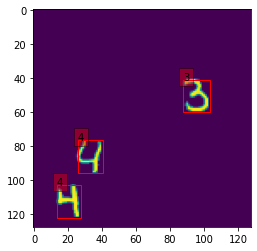

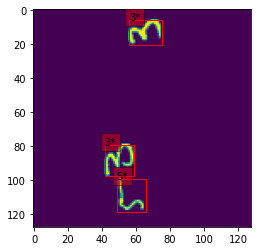

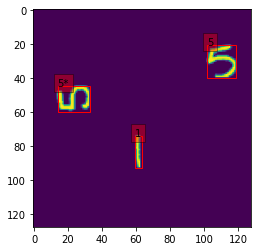

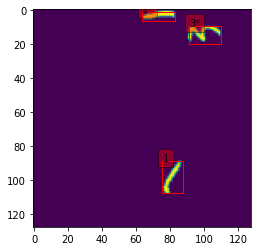

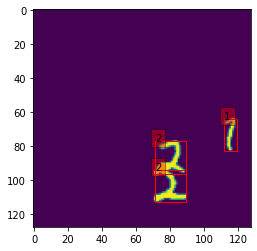

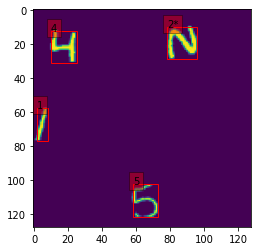

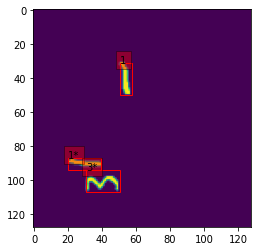

Incorrect predictions:


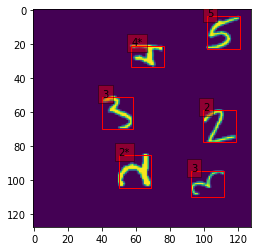

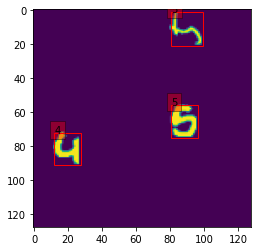

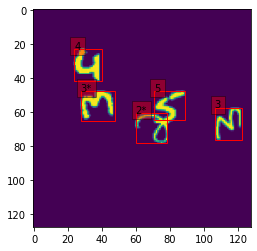

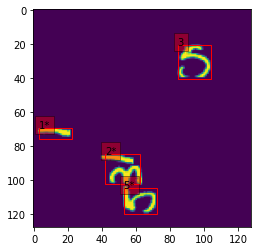

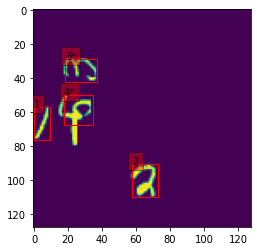

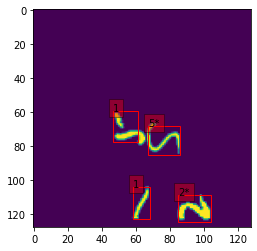

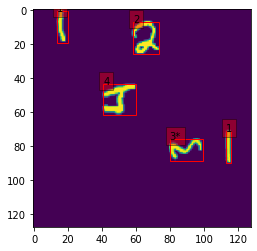

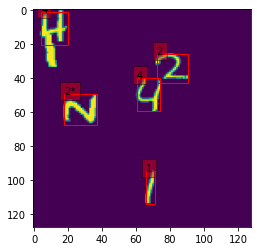

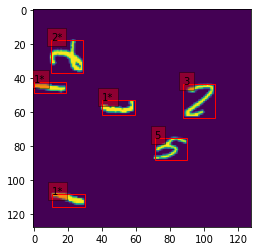

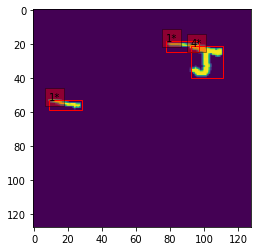

Loss: 0.229,	Acc: 166/256	[64.84%]
----- Epoch 15 -----
[Epoch: 15, Batch: 50]		Loss: 0.185
[Epoch: 15, Batch: 100]		Loss: 0.174
[Epoch: 15, Batch: 150]		Loss: 0.177
[Epoch: 15, Batch: 200]		Loss: 0.171
[Epoch: 15, Batch: 250]		Loss: 0.176
[Epoch: 15, Batch: 300]		Loss: 0.176
[Epoch: 15, Batch: 350]		Loss: 0.175
[Epoch: 15, Batch: 400]		Loss: 0.173
[Epoch: 15, Batch: 450]		Loss: 0.168
[Epoch: 15, Batch: 500]		Loss: 0.166
[Epoch: 15, Batch: 550]		Loss: 0.165
[Epoch: 15, Batch: 600]		Loss: 0.165
[Epoch: 15, Batch: 650]		Loss: 0.166
[Epoch: 15, Batch: 700]		Loss: 0.165
[Epoch: 15, Batch: 750]		Loss: 0.163
[Epoch: 15, Batch: 800]		Loss: 0.164
[Epoch: 15, Batch: 850]		Loss: 0.161
[Epoch: 15, Batch: 900]		Loss: 0.160
[Epoch: 15, Batch: 950]		Loss: 0.161
[Epoch: 15, Batch: 1000]		Loss: 0.161
[Epoch: 15, Batch: 1050]		Loss: 0.160
[Epoch: 15, Batch: 1100]		Loss: 0.159
[Epoch: 15, Batch: 1150]		Loss: 0.158
[Epoch: 15, Batch: 1200]		Loss: 0.157
[Epoch: 15, Batch: 1250]		Loss: 0.157
[Epoch: 15, Ba

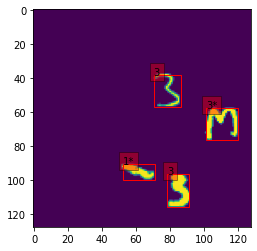

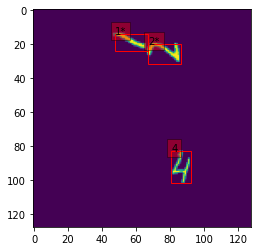

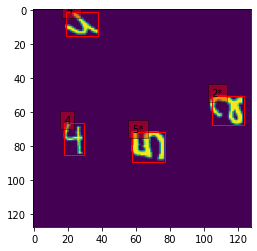

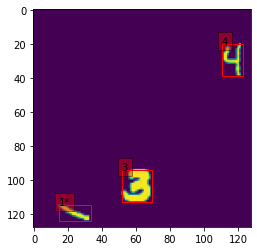

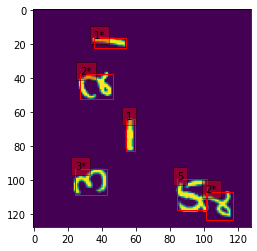

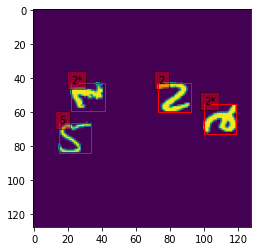

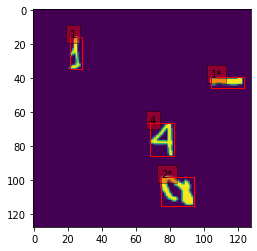

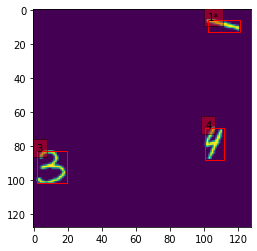

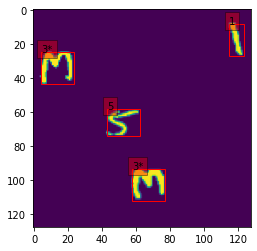

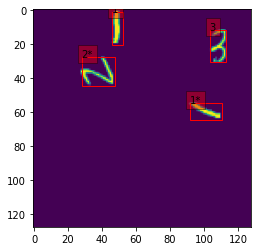

Incorrect predictions:


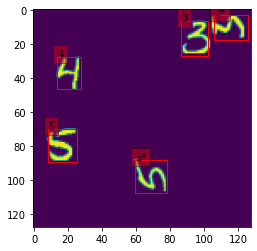

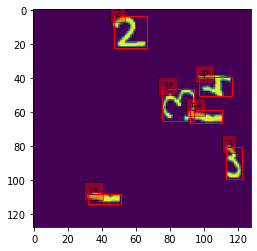

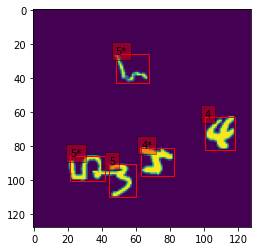

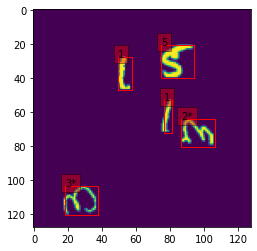

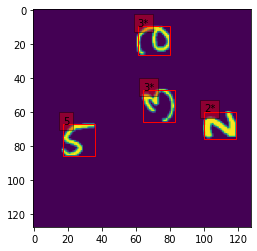

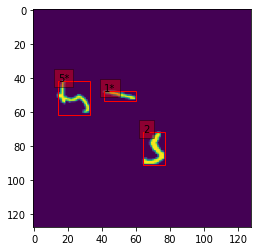

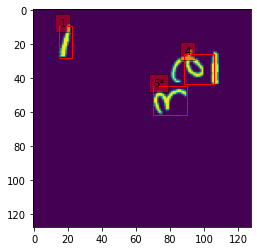

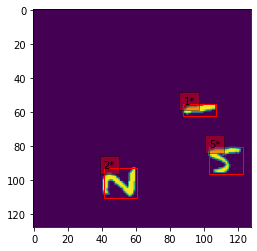

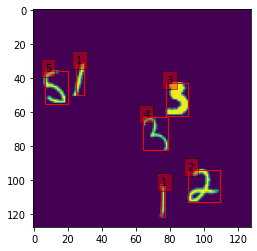

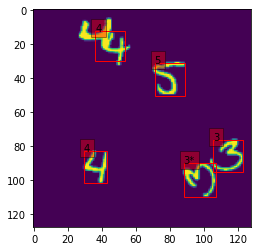

Loss: 0.213,	Acc: 173/256	[67.58%]
----- Epoch 16 -----
[Epoch: 16, Batch: 50]		Loss: 0.173
[Epoch: 16, Batch: 100]		Loss: 0.163
[Epoch: 16, Batch: 150]		Loss: 0.167
[Epoch: 16, Batch: 200]		Loss: 0.160
[Epoch: 16, Batch: 250]		Loss: 0.165
[Epoch: 16, Batch: 300]		Loss: 0.165
[Epoch: 16, Batch: 350]		Loss: 0.164
[Epoch: 16, Batch: 400]		Loss: 0.163
[Epoch: 16, Batch: 450]		Loss: 0.158
[Epoch: 16, Batch: 500]		Loss: 0.157
[Epoch: 16, Batch: 550]		Loss: 0.156
[Epoch: 16, Batch: 600]		Loss: 0.155
[Epoch: 16, Batch: 650]		Loss: 0.156
[Epoch: 16, Batch: 700]		Loss: 0.156
[Epoch: 16, Batch: 750]		Loss: 0.153
[Epoch: 16, Batch: 800]		Loss: 0.155
[Epoch: 16, Batch: 850]		Loss: 0.152
[Epoch: 16, Batch: 900]		Loss: 0.151
[Epoch: 16, Batch: 950]		Loss: 0.152
[Epoch: 16, Batch: 1000]		Loss: 0.151
[Epoch: 16, Batch: 1050]		Loss: 0.151
[Epoch: 16, Batch: 1100]		Loss: 0.149
[Epoch: 16, Batch: 1150]		Loss: 0.149
[Epoch: 16, Batch: 1200]		Loss: 0.148
[Epoch: 16, Batch: 1250]		Loss: 0.148
[Epoch: 16, Ba

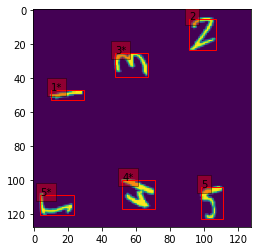

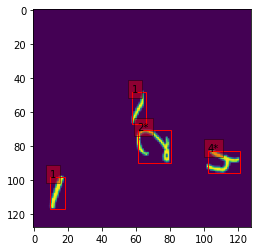

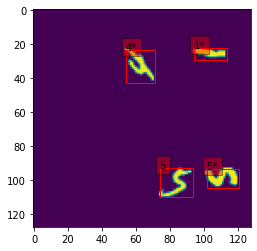

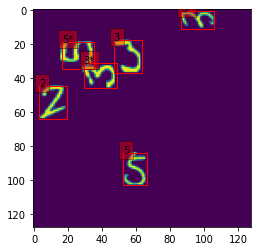

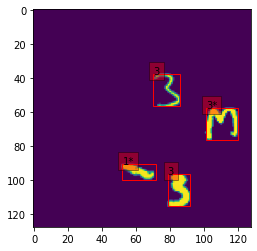

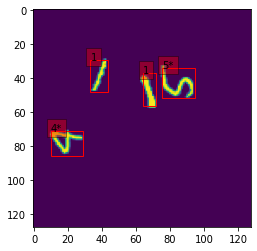

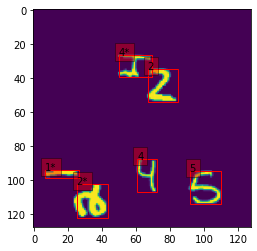

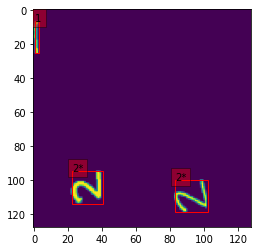

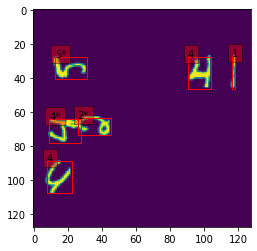

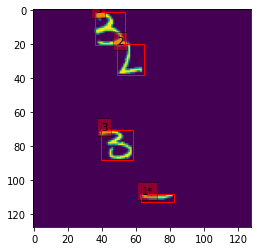

Incorrect predictions:


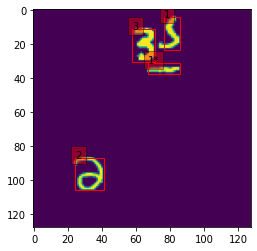

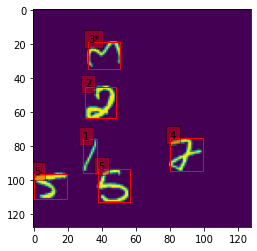

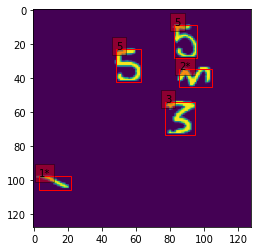

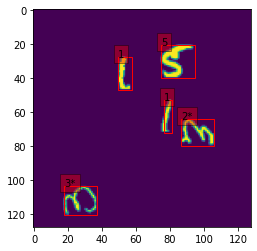

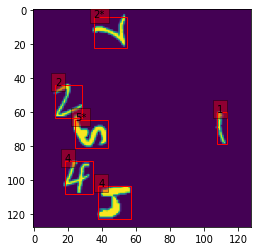

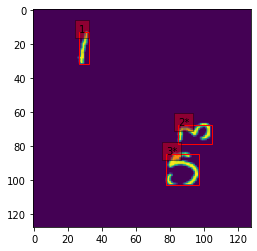

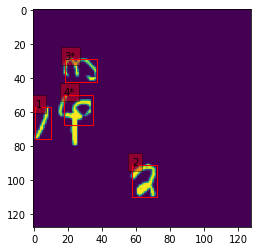

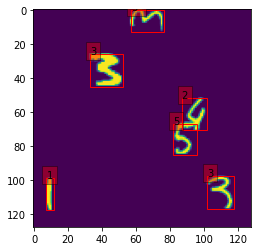

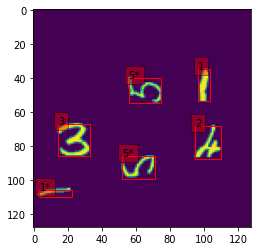

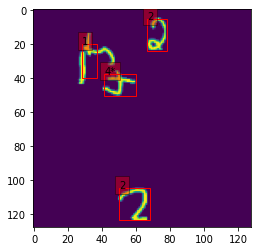

Loss: 0.207,	Acc: 176/256	[68.75%]
----- Epoch 17 -----
[Epoch: 17, Batch: 50]		Loss: 0.164
[Epoch: 17, Batch: 100]		Loss: 0.153
[Epoch: 17, Batch: 150]		Loss: 0.156
[Epoch: 17, Batch: 200]		Loss: 0.151
[Epoch: 17, Batch: 250]		Loss: 0.155
[Epoch: 17, Batch: 300]		Loss: 0.156
[Epoch: 17, Batch: 350]		Loss: 0.156
[Epoch: 17, Batch: 400]		Loss: 0.155
[Epoch: 17, Batch: 450]		Loss: 0.151
[Epoch: 17, Batch: 500]		Loss: 0.150
[Epoch: 17, Batch: 550]		Loss: 0.148
[Epoch: 17, Batch: 600]		Loss: 0.147
[Epoch: 17, Batch: 650]		Loss: 0.148
[Epoch: 17, Batch: 700]		Loss: 0.148
[Epoch: 17, Batch: 750]		Loss: 0.146
[Epoch: 17, Batch: 800]		Loss: 0.147
[Epoch: 17, Batch: 850]		Loss: 0.144
[Epoch: 17, Batch: 900]		Loss: 0.143
[Epoch: 17, Batch: 950]		Loss: 0.144
[Epoch: 17, Batch: 1000]		Loss: 0.144
[Epoch: 17, Batch: 1050]		Loss: 0.143
[Epoch: 17, Batch: 1100]		Loss: 0.142
[Epoch: 17, Batch: 1150]		Loss: 0.141
[Epoch: 17, Batch: 1200]		Loss: 0.140
[Epoch: 17, Batch: 1250]		Loss: 0.140
[Epoch: 17, Ba

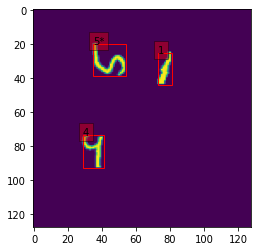

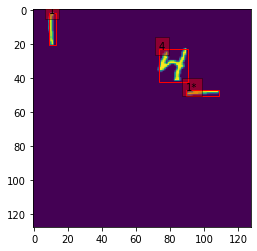

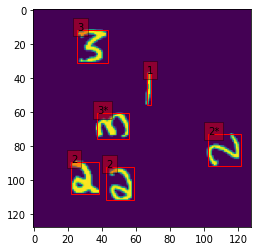

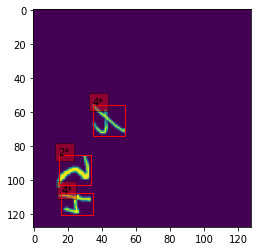

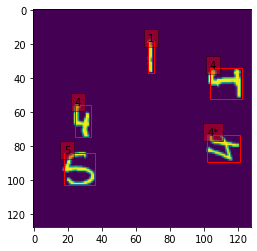

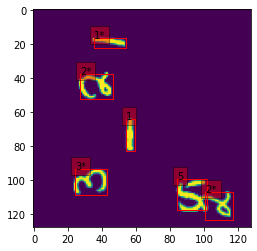

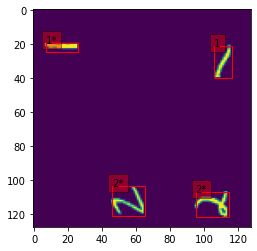

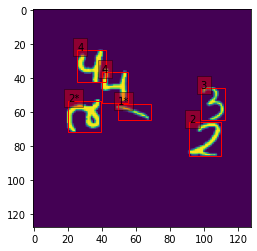

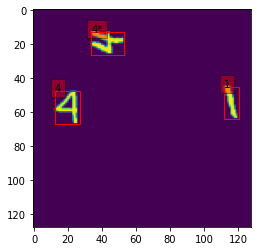

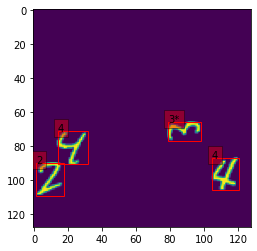

Incorrect predictions:


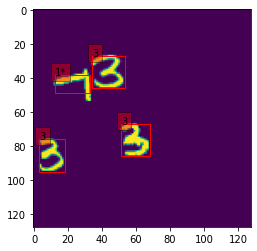

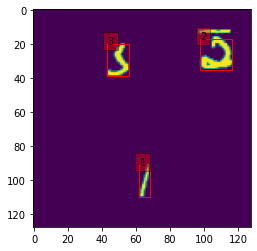

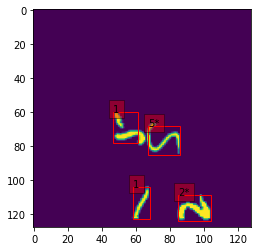

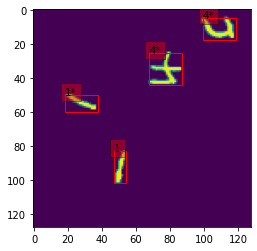

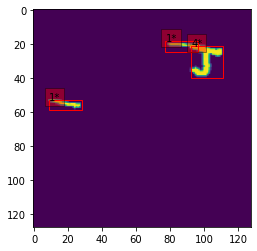

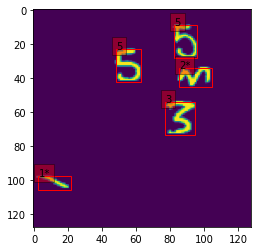

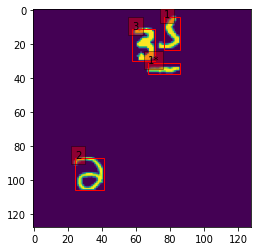

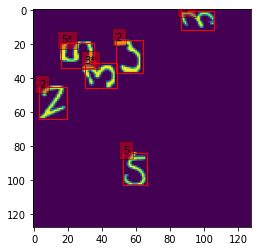

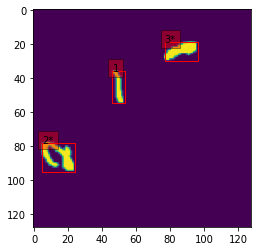

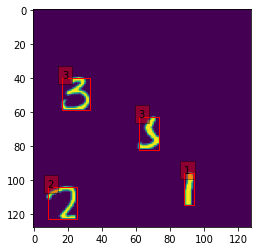

Loss: 0.202,	Acc: 175/256	[68.36%]
----- Epoch 18 -----
[Epoch: 18, Batch: 50]		Loss: 0.156
[Epoch: 18, Batch: 100]		Loss: 0.146
[Epoch: 18, Batch: 150]		Loss: 0.149
[Epoch: 18, Batch: 200]		Loss: 0.143
[Epoch: 18, Batch: 250]		Loss: 0.147
[Epoch: 18, Batch: 300]		Loss: 0.149
[Epoch: 18, Batch: 350]		Loss: 0.149
[Epoch: 18, Batch: 400]		Loss: 0.148
[Epoch: 18, Batch: 450]		Loss: 0.145
[Epoch: 18, Batch: 500]		Loss: 0.145
[Epoch: 18, Batch: 550]		Loss: 0.143
[Epoch: 18, Batch: 600]		Loss: 0.142
[Epoch: 18, Batch: 650]		Loss: 0.143
[Epoch: 18, Batch: 700]		Loss: 0.143
[Epoch: 18, Batch: 750]		Loss: 0.140
[Epoch: 18, Batch: 800]		Loss: 0.141
[Epoch: 18, Batch: 850]		Loss: 0.139
[Epoch: 18, Batch: 900]		Loss: 0.138
[Epoch: 18, Batch: 950]		Loss: 0.138
[Epoch: 18, Batch: 1000]		Loss: 0.138
[Epoch: 18, Batch: 1050]		Loss: 0.137
[Epoch: 18, Batch: 1100]		Loss: 0.136
[Epoch: 18, Batch: 1150]		Loss: 0.135
[Epoch: 18, Batch: 1200]		Loss: 0.135
[Epoch: 18, Batch: 1250]		Loss: 0.134
[Epoch: 18, Ba

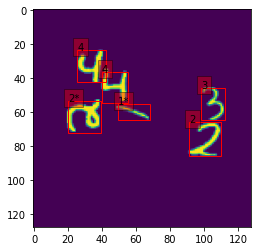

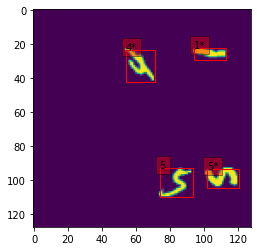

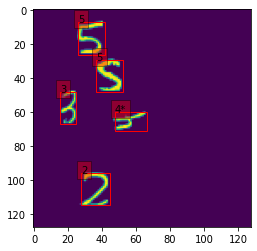

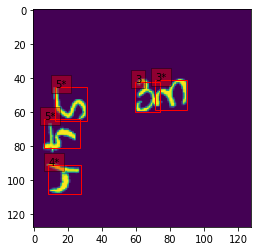

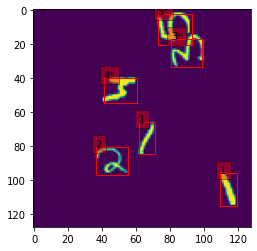

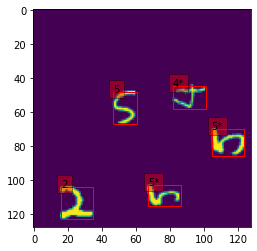

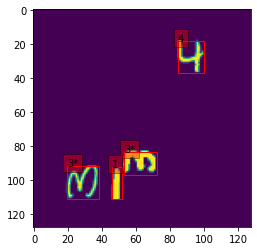

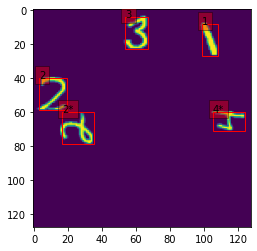

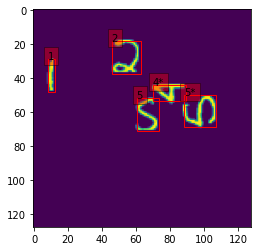

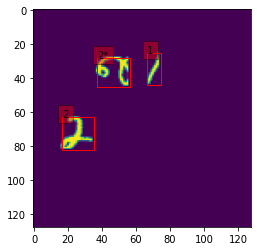

Incorrect predictions:


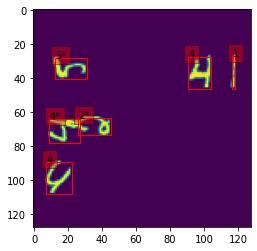

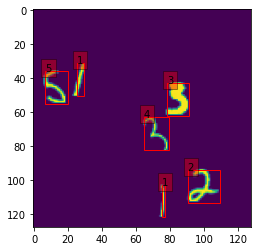

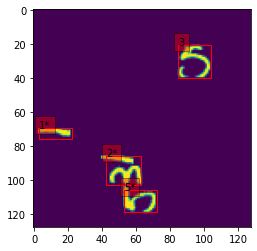

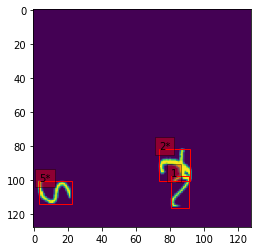

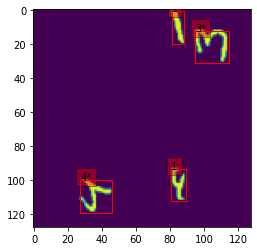

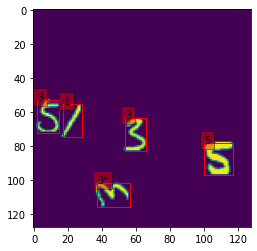

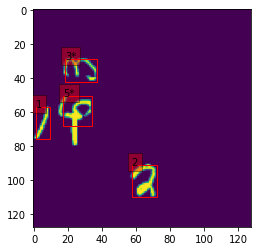

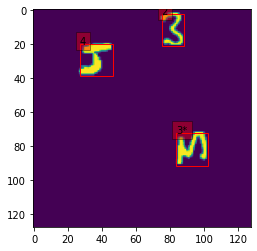

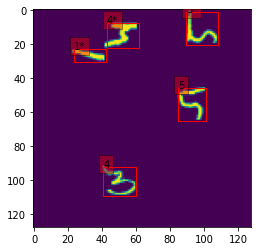

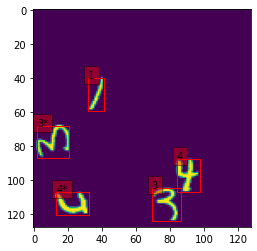

Loss: 0.191,	Acc: 179/256	[69.92%]
----- Epoch 19 -----
[Epoch: 19, Batch: 50]		Loss: 0.147
[Epoch: 19, Batch: 100]		Loss: 0.137
[Epoch: 19, Batch: 150]		Loss: 0.140
[Epoch: 19, Batch: 200]		Loss: 0.134
[Epoch: 19, Batch: 250]		Loss: 0.139
[Epoch: 19, Batch: 300]		Loss: 0.141
[Epoch: 19, Batch: 350]		Loss: 0.141
[Epoch: 19, Batch: 400]		Loss: 0.140
[Epoch: 19, Batch: 450]		Loss: 0.138
[Epoch: 19, Batch: 500]		Loss: 0.137
[Epoch: 19, Batch: 550]		Loss: 0.135
[Epoch: 19, Batch: 600]		Loss: 0.135
[Epoch: 19, Batch: 650]		Loss: 0.135
[Epoch: 19, Batch: 700]		Loss: 0.136
[Epoch: 19, Batch: 750]		Loss: 0.133
[Epoch: 19, Batch: 800]		Loss: 0.134
[Epoch: 19, Batch: 850]		Loss: 0.131
[Epoch: 19, Batch: 900]		Loss: 0.131
[Epoch: 19, Batch: 950]		Loss: 0.131
[Epoch: 19, Batch: 1000]		Loss: 0.131
[Epoch: 19, Batch: 1050]		Loss: 0.130
[Epoch: 19, Batch: 1100]		Loss: 0.128
[Epoch: 19, Batch: 1150]		Loss: 0.128
[Epoch: 19, Batch: 1200]		Loss: 0.127
[Epoch: 19, Batch: 1250]		Loss: 0.127
[Epoch: 19, Ba

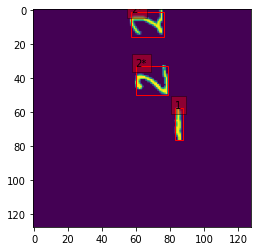

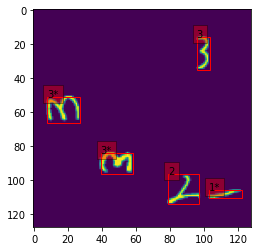

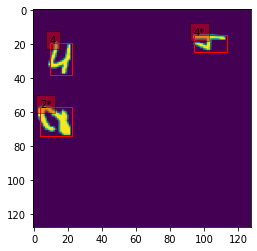

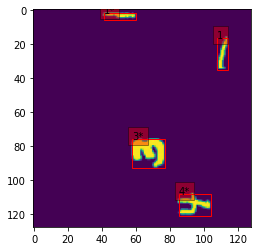

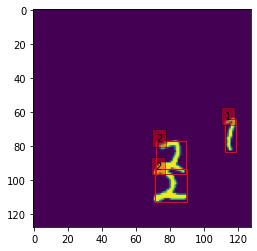

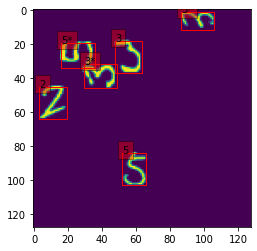

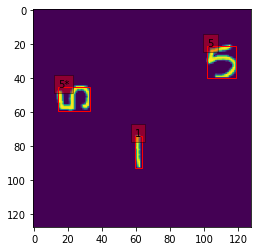

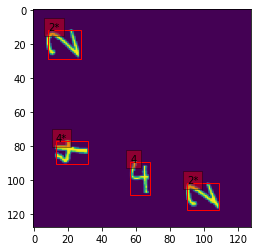

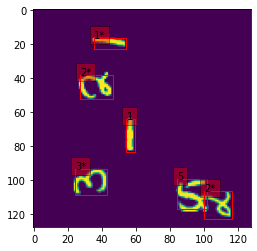

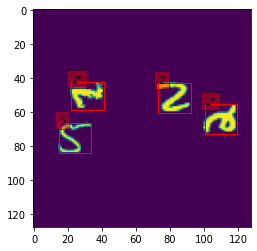

Incorrect predictions:


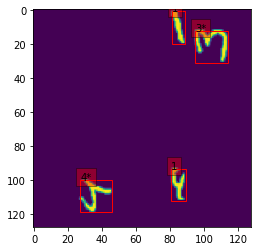

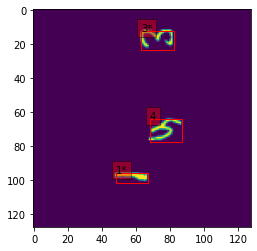

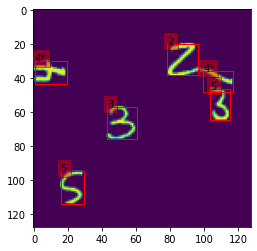

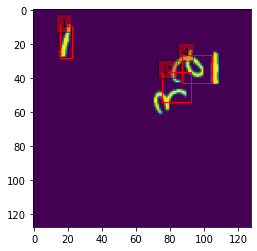

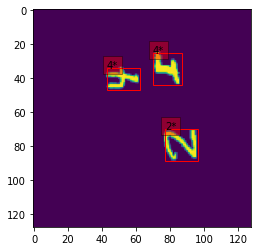

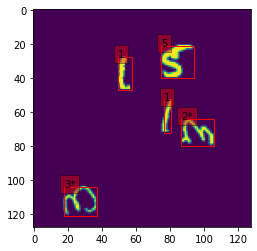

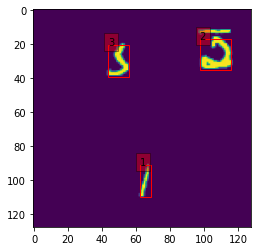

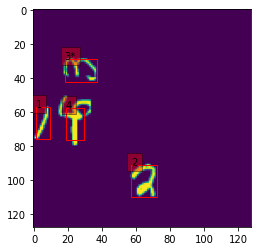

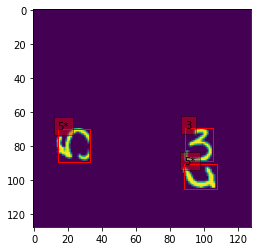

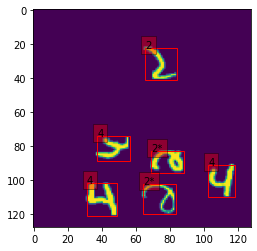

Loss: 0.192,	Acc: 178/256	[69.53%]
----- Epoch 20 -----
[Epoch: 20, Batch: 50]		Loss: 0.139
[Epoch: 20, Batch: 100]		Loss: 0.129
[Epoch: 20, Batch: 150]		Loss: 0.132
[Epoch: 20, Batch: 200]		Loss: 0.126
[Epoch: 20, Batch: 250]		Loss: 0.131
[Epoch: 20, Batch: 300]		Loss: 0.132
[Epoch: 20, Batch: 350]		Loss: 0.132
[Epoch: 20, Batch: 400]		Loss: 0.131
[Epoch: 20, Batch: 450]		Loss: 0.128
[Epoch: 20, Batch: 500]		Loss: 0.127
[Epoch: 20, Batch: 550]		Loss: 0.126
[Epoch: 20, Batch: 600]		Loss: 0.125
[Epoch: 20, Batch: 650]		Loss: 0.126
[Epoch: 20, Batch: 700]		Loss: 0.127
[Epoch: 20, Batch: 750]		Loss: 0.125
[Epoch: 20, Batch: 800]		Loss: 0.125
[Epoch: 20, Batch: 850]		Loss: 0.123
[Epoch: 20, Batch: 900]		Loss: 0.122
[Epoch: 20, Batch: 950]		Loss: 0.122
[Epoch: 20, Batch: 1000]		Loss: 0.122
[Epoch: 20, Batch: 1050]		Loss: 0.121
[Epoch: 20, Batch: 1100]		Loss: 0.120
[Epoch: 20, Batch: 1150]		Loss: 0.120
[Epoch: 20, Batch: 1200]		Loss: 0.119
[Epoch: 20, Batch: 1250]		Loss: 0.119
[Epoch: 20, Ba

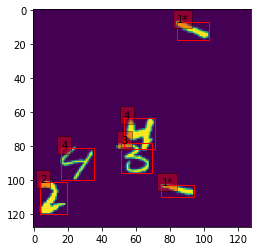

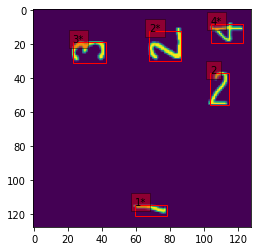

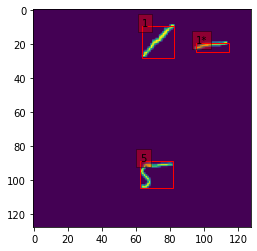

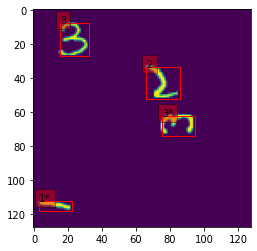

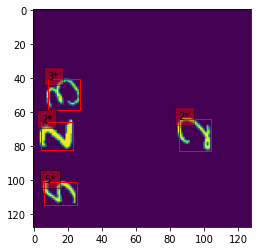

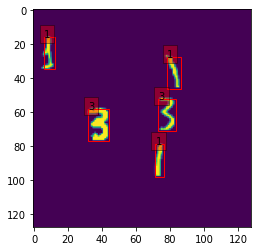

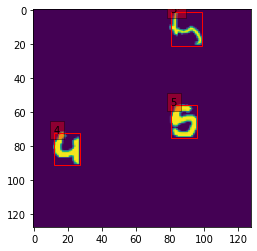

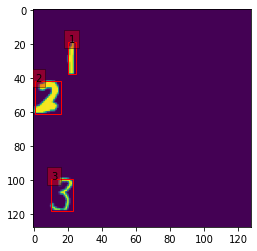

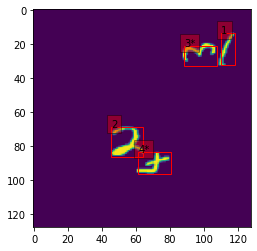

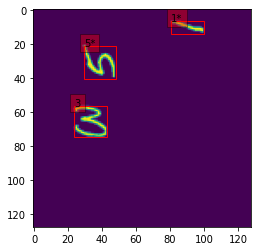

Incorrect predictions:


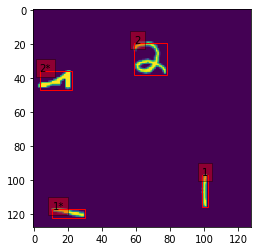

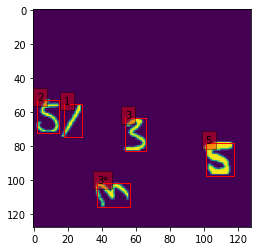

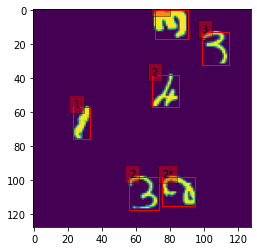

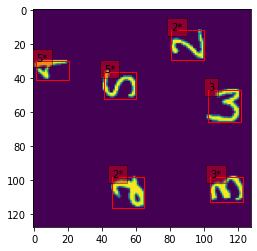

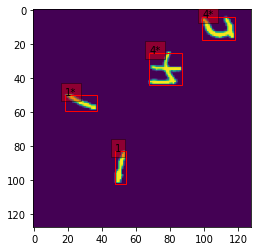

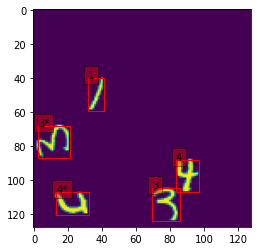

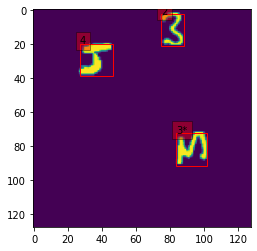

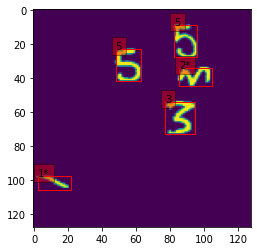

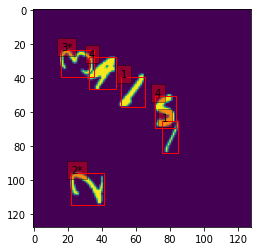

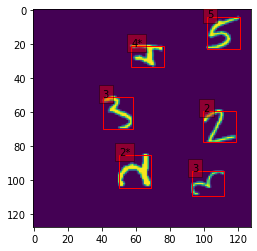

Loss: 0.187,	Acc: 179/256	[69.92%]
----- Epoch 21 -----
[Epoch: 21, Batch: 50]		Loss: 0.130
[Epoch: 21, Batch: 100]		Loss: 0.122
[Epoch: 21, Batch: 150]		Loss: 0.124
[Epoch: 21, Batch: 200]		Loss: 0.119
[Epoch: 21, Batch: 250]		Loss: 0.124
[Epoch: 21, Batch: 300]		Loss: 0.125
[Epoch: 21, Batch: 350]		Loss: 0.125
[Epoch: 21, Batch: 400]		Loss: 0.123
[Epoch: 21, Batch: 450]		Loss: 0.121
[Epoch: 21, Batch: 500]		Loss: 0.119
[Epoch: 21, Batch: 550]		Loss: 0.118
[Epoch: 21, Batch: 600]		Loss: 0.117
[Epoch: 21, Batch: 650]		Loss: 0.118
[Epoch: 21, Batch: 700]		Loss: 0.119
[Epoch: 21, Batch: 750]		Loss: 0.117
[Epoch: 21, Batch: 800]		Loss: 0.117
[Epoch: 21, Batch: 850]		Loss: 0.115
[Epoch: 21, Batch: 900]		Loss: 0.114
[Epoch: 21, Batch: 950]		Loss: 0.114
[Epoch: 21, Batch: 1000]		Loss: 0.114
[Epoch: 21, Batch: 1050]		Loss: 0.113
[Epoch: 21, Batch: 1100]		Loss: 0.112
[Epoch: 21, Batch: 1150]		Loss: 0.112
[Epoch: 21, Batch: 1200]		Loss: 0.111
[Epoch: 21, Batch: 1250]		Loss: 0.111
[Epoch: 21, Ba

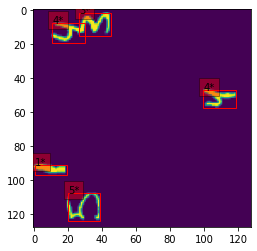

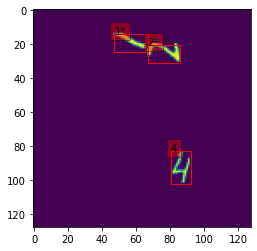

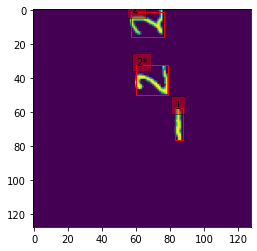

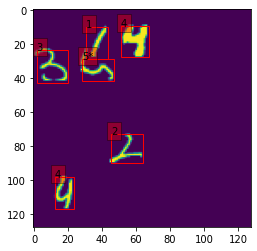

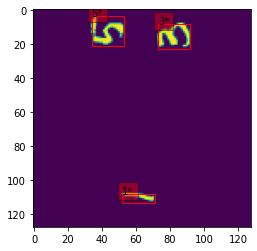

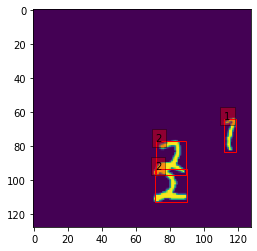

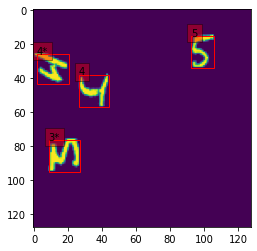

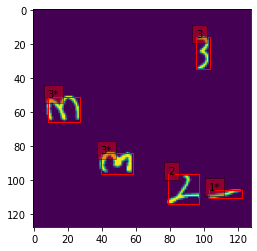

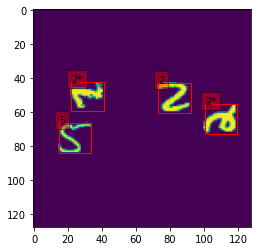

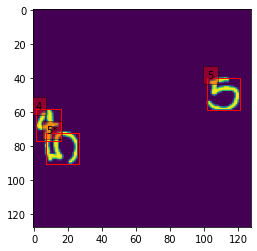

Incorrect predictions:


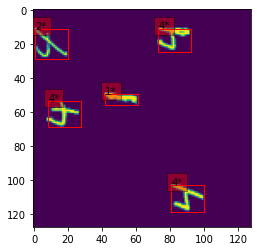

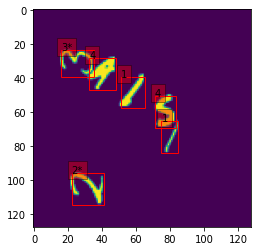

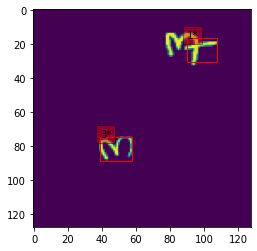

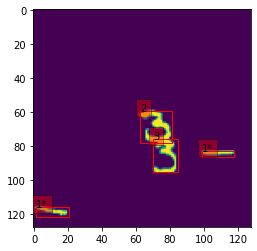

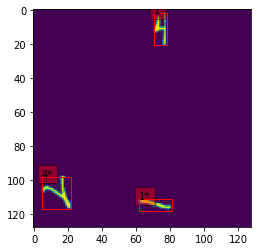

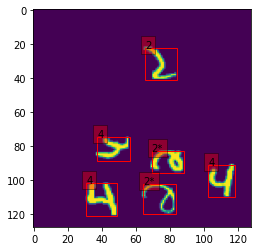

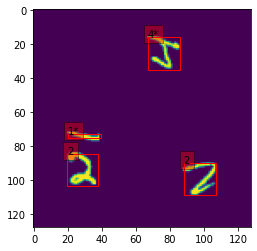

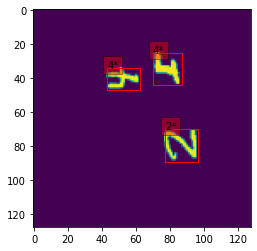

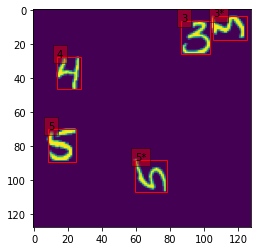

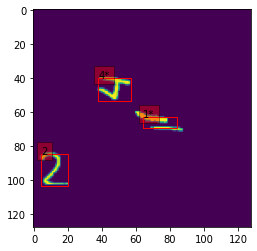

Loss: 0.185,	Acc: 184/256	[71.88%]
----- Epoch 22 -----
[Epoch: 22, Batch: 50]		Loss: 0.126
[Epoch: 22, Batch: 100]		Loss: 0.118
[Epoch: 22, Batch: 150]		Loss: 0.120
[Epoch: 22, Batch: 200]		Loss: 0.115
[Epoch: 22, Batch: 250]		Loss: 0.119
[Epoch: 22, Batch: 300]		Loss: 0.120
[Epoch: 22, Batch: 350]		Loss: 0.120
[Epoch: 22, Batch: 400]		Loss: 0.118
[Epoch: 22, Batch: 450]		Loss: 0.116
[Epoch: 22, Batch: 500]		Loss: 0.114
[Epoch: 22, Batch: 550]		Loss: 0.112
[Epoch: 22, Batch: 600]		Loss: 0.112
[Epoch: 22, Batch: 650]		Loss: 0.113
[Epoch: 22, Batch: 700]		Loss: 0.114
[Epoch: 22, Batch: 750]		Loss: 0.112
[Epoch: 22, Batch: 800]		Loss: 0.112
[Epoch: 22, Batch: 850]		Loss: 0.110
[Epoch: 22, Batch: 900]		Loss: 0.110
[Epoch: 22, Batch: 950]		Loss: 0.110
[Epoch: 22, Batch: 1000]		Loss: 0.110
[Epoch: 22, Batch: 1050]		Loss: 0.109
[Epoch: 22, Batch: 1100]		Loss: 0.108
[Epoch: 22, Batch: 1150]		Loss: 0.107
[Epoch: 22, Batch: 1200]		Loss: 0.107
[Epoch: 22, Batch: 1250]		Loss: 0.107
[Epoch: 22, Ba

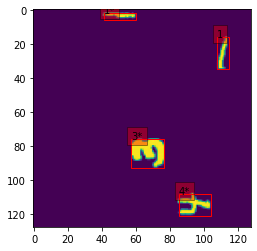

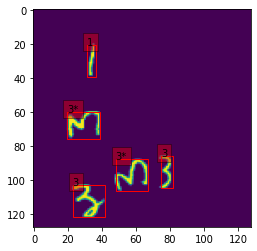

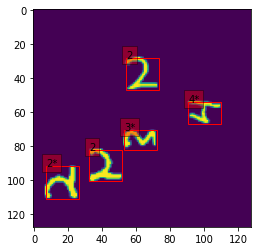

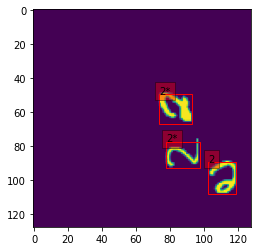

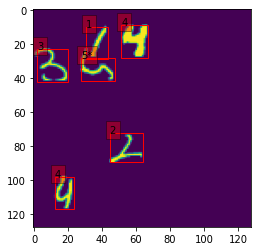

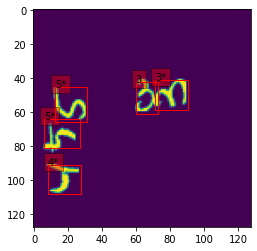

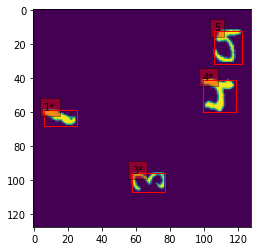

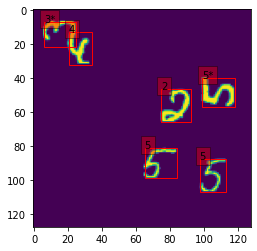

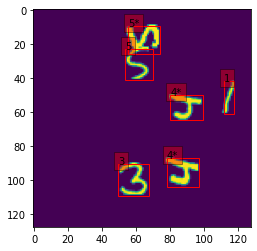

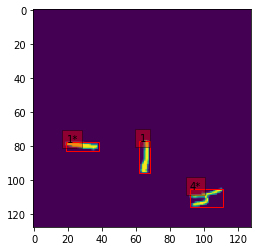

Incorrect predictions:


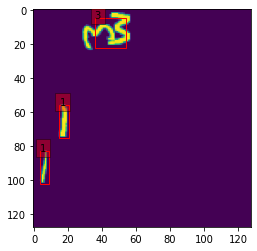

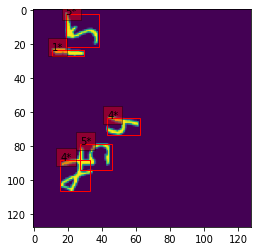

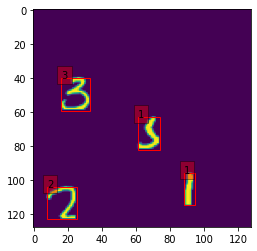

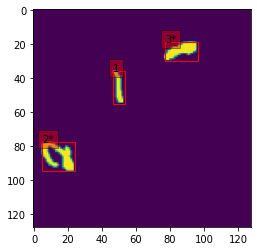

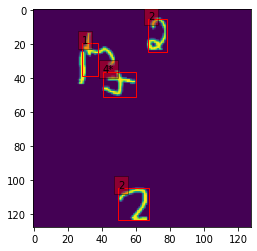

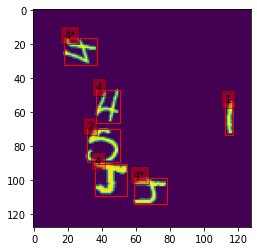

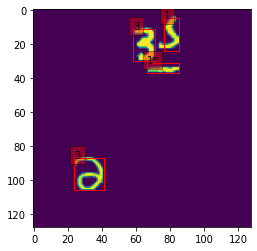

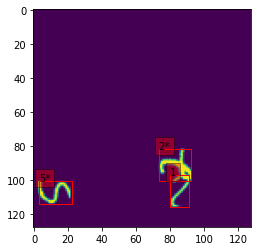

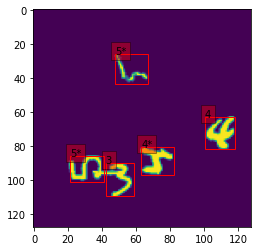

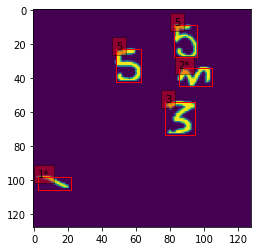

Loss: 0.199,	Acc: 182/256	[71.09%]
----- Epoch 23 -----
[Epoch: 23, Batch: 50]		Loss: 0.122
[Epoch: 23, Batch: 100]		Loss: 0.116
[Epoch: 23, Batch: 150]		Loss: 0.116
[Epoch: 23, Batch: 200]		Loss: 0.111
[Epoch: 23, Batch: 250]		Loss: 0.118
[Epoch: 23, Batch: 300]		Loss: 0.121
[Epoch: 23, Batch: 350]		Loss: 0.121
[Epoch: 23, Batch: 400]		Loss: 0.120
[Epoch: 23, Batch: 450]		Loss: 0.117
[Epoch: 23, Batch: 500]		Loss: 0.114
[Epoch: 23, Batch: 550]		Loss: 0.113
[Epoch: 23, Batch: 600]		Loss: 0.113
[Epoch: 23, Batch: 650]		Loss: 0.114
[Epoch: 23, Batch: 700]		Loss: 0.115
[Epoch: 23, Batch: 750]		Loss: 0.114
[Epoch: 23, Batch: 800]		Loss: 0.113
[Epoch: 23, Batch: 850]		Loss: 0.111
[Epoch: 23, Batch: 900]		Loss: 0.110
[Epoch: 23, Batch: 950]		Loss: 0.110
[Epoch: 23, Batch: 1000]		Loss: 0.109
[Epoch: 23, Batch: 1050]		Loss: 0.108
[Epoch: 23, Batch: 1100]		Loss: 0.107
[Epoch: 23, Batch: 1150]		Loss: 0.107
[Epoch: 23, Batch: 1200]		Loss: 0.107
[Epoch: 23, Batch: 1250]		Loss: 0.107
[Epoch: 23, Ba

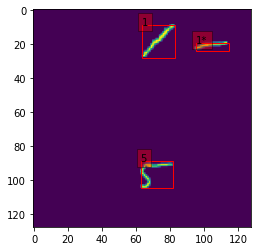

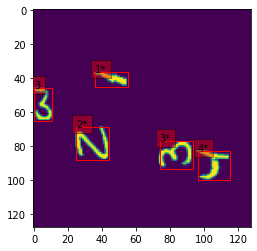

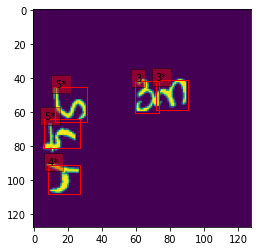

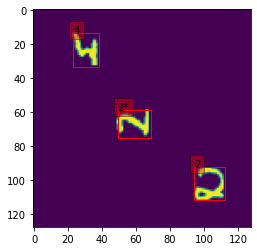

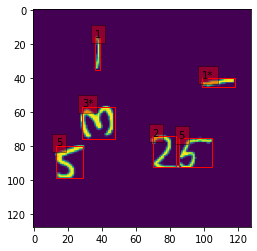

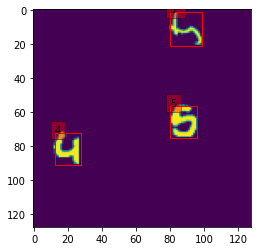

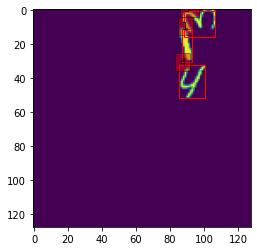

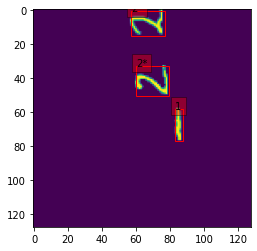

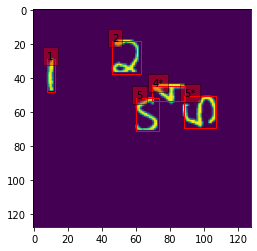

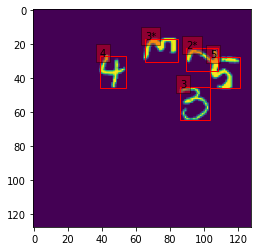

Incorrect predictions:


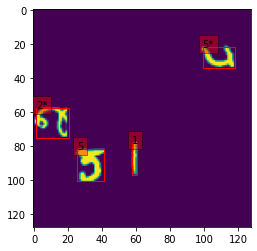

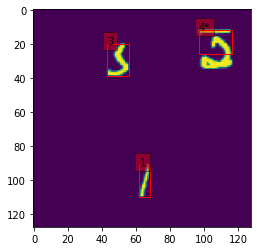

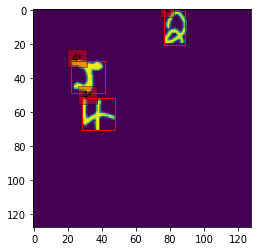

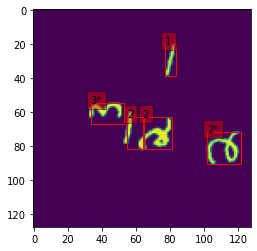

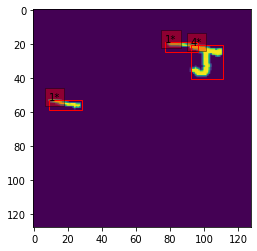

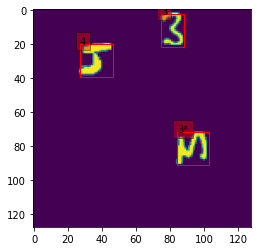

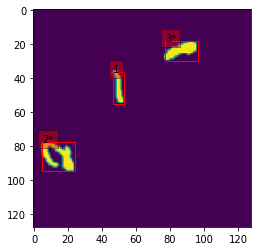

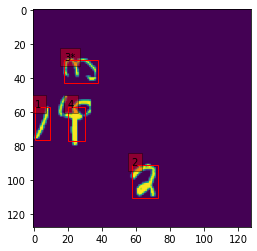

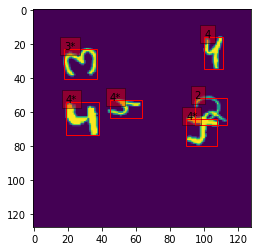

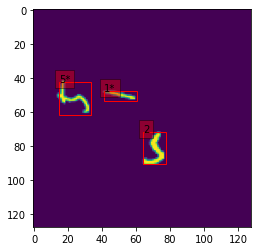

Loss: 0.195,	Acc: 180/256	[70.31%]
----- Epoch 24 -----
[Epoch: 24, Batch: 50]		Loss: 0.132
[Epoch: 24, Batch: 100]		Loss: 0.120
[Epoch: 24, Batch: 150]		Loss: 0.118
[Epoch: 24, Batch: 200]		Loss: 0.111
[Epoch: 24, Batch: 250]		Loss: 0.116
[Epoch: 24, Batch: 300]		Loss: 0.118
[Epoch: 24, Batch: 350]		Loss: 0.117
[Epoch: 24, Batch: 400]		Loss: 0.115
[Epoch: 24, Batch: 450]		Loss: 0.112
[Epoch: 24, Batch: 500]		Loss: 0.109
[Epoch: 24, Batch: 550]		Loss: 0.107
[Epoch: 24, Batch: 600]		Loss: 0.107
[Epoch: 24, Batch: 650]		Loss: 0.108
[Epoch: 24, Batch: 700]		Loss: 0.109
[Epoch: 24, Batch: 750]		Loss: 0.107
[Epoch: 24, Batch: 800]		Loss: 0.106
[Epoch: 24, Batch: 850]		Loss: 0.104
[Epoch: 24, Batch: 900]		Loss: 0.103
[Epoch: 24, Batch: 950]		Loss: 0.103
[Epoch: 24, Batch: 1000]		Loss: 0.103
[Epoch: 24, Batch: 1050]		Loss: 0.102
[Epoch: 24, Batch: 1100]		Loss: 0.101
[Epoch: 24, Batch: 1150]		Loss: 0.101
[Epoch: 24, Batch: 1200]		Loss: 0.100
[Epoch: 24, Batch: 1250]		Loss: 0.101
[Epoch: 24, Ba

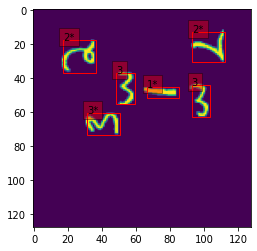

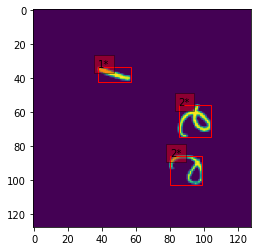

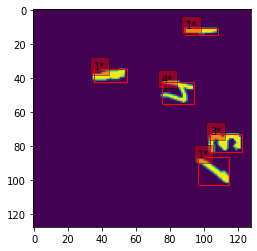

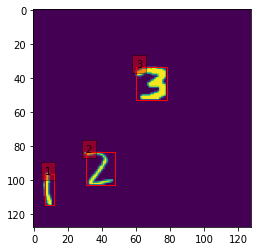

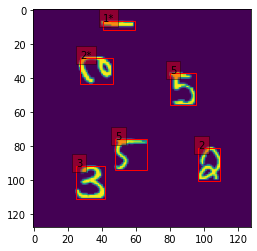

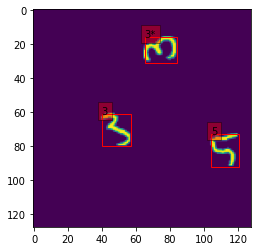

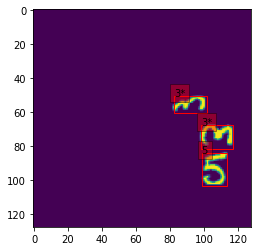

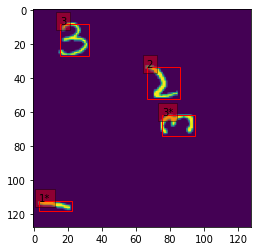

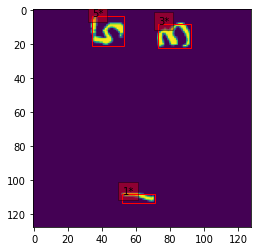

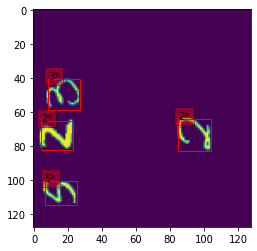

Incorrect predictions:


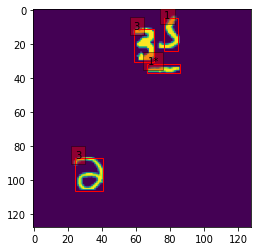

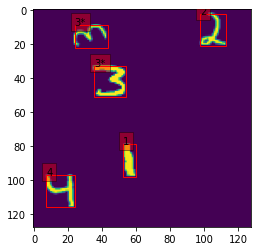

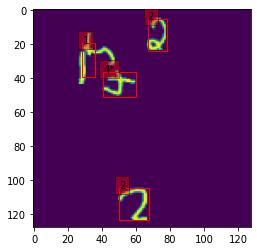

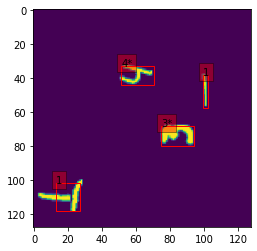

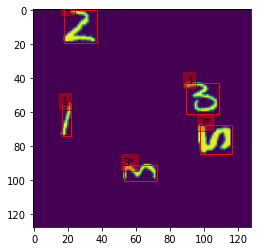

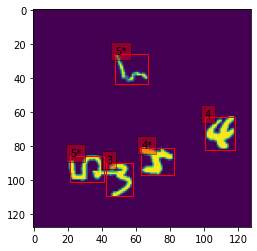

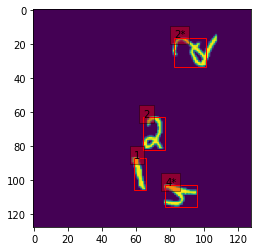

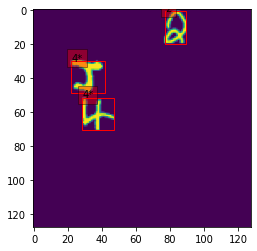

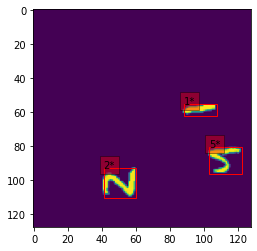

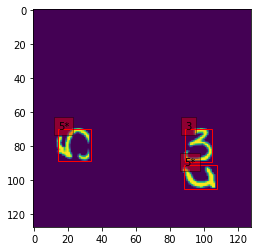

Loss: 0.184,	Acc: 179/256	[69.92%]
----- Epoch 25 -----
[Epoch: 25, Batch: 50]		Loss: 0.121
[Epoch: 25, Batch: 100]		Loss: 0.112
[Epoch: 25, Batch: 150]		Loss: 0.111
[Epoch: 25, Batch: 200]		Loss: 0.104
[Epoch: 25, Batch: 250]		Loss: 0.108
[Epoch: 25, Batch: 300]		Loss: 0.108
[Epoch: 25, Batch: 350]		Loss: 0.107
[Epoch: 25, Batch: 400]		Loss: 0.105
[Epoch: 25, Batch: 450]		Loss: 0.102
[Epoch: 25, Batch: 500]		Loss: 0.099
[Epoch: 25, Batch: 550]		Loss: 0.098
[Epoch: 25, Batch: 600]		Loss: 0.098
[Epoch: 25, Batch: 650]		Loss: 0.099
[Epoch: 25, Batch: 700]		Loss: 0.099
[Epoch: 25, Batch: 750]		Loss: 0.098
[Epoch: 25, Batch: 800]		Loss: 0.097
[Epoch: 25, Batch: 850]		Loss: 0.095
[Epoch: 25, Batch: 900]		Loss: 0.095
[Epoch: 25, Batch: 950]		Loss: 0.095
[Epoch: 25, Batch: 1000]		Loss: 0.094
[Epoch: 25, Batch: 1050]		Loss: 0.094
[Epoch: 25, Batch: 1100]		Loss: 0.093
[Epoch: 25, Batch: 1150]		Loss: 0.093
[Epoch: 25, Batch: 1200]		Loss: 0.092
[Epoch: 25, Batch: 1250]		Loss: 0.092
[Epoch: 25, Ba

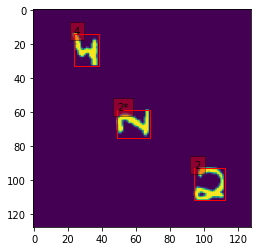

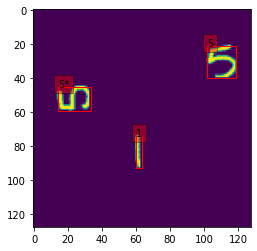

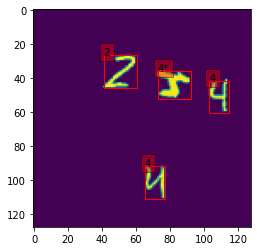

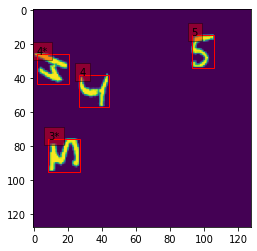

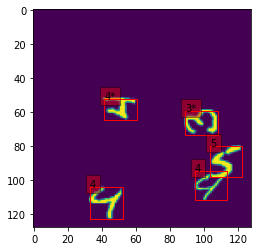

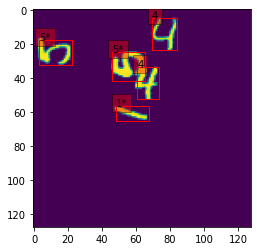

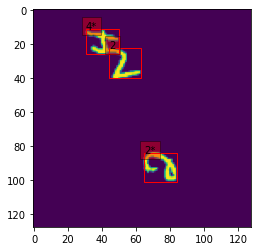

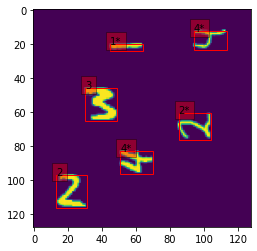

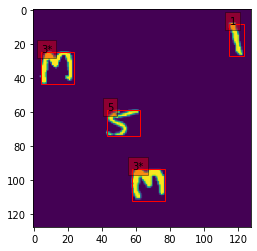

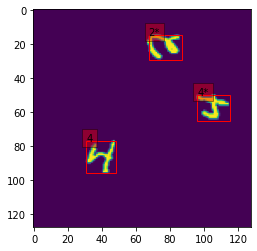

Incorrect predictions:


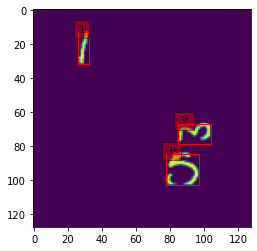

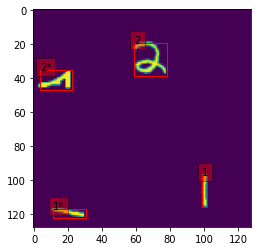

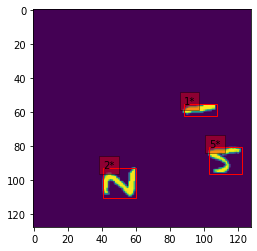

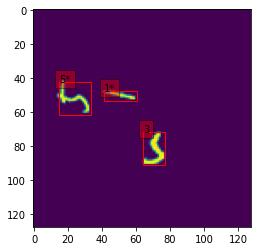

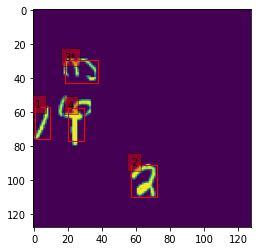

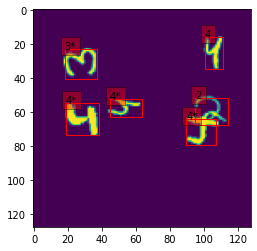

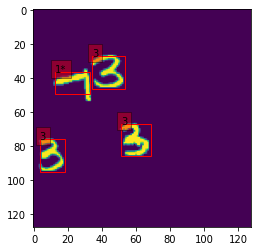

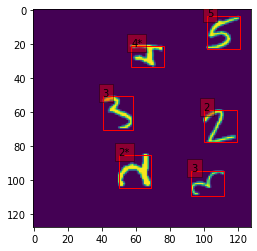

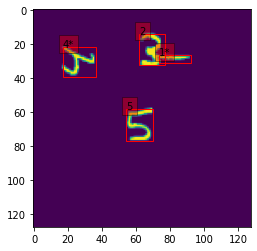

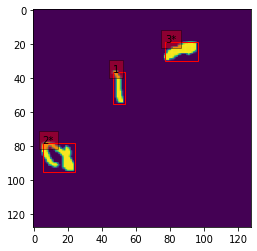

Loss: 0.181,	Acc: 180/256	[70.31%]


In [13]:
model = train(canvases=TRAIN_CANVAS, log_interval_epoch=1)

In [14]:
_, _, _, _, losses, test_accs, test_losses = get_model(False)

[Epoch: 25]	Loss: 0.089


In [17]:
import plotly.graph_objects as go

xs = np.linspace(1, len(losses), len(losses))
fig = go.Figure()
fig.add_trace(go.Scatter(x=xs, y=losses, mode='lines', name='train_loss'))
fig.update_layout(title='Train loss', xaxis_title='epochs')
fig.show()
fig = go.Figure()
fig.add_trace(go.Scatter(x=xs, y=np.array(test_losses)/256, mode='lines', name='test_loss'))
fig.update_layout(title='Test loss', xaxis_title='epochs')
fig.show()
fig = go.Figure()
fig.add_trace(go.Scatter(x=xs, y=test_accs, mode='lines', name='test_acc'))
fig.update_layout(title='Test accuracy', xaxis_title='epochs')
fig.show()

## Report

Model achieves satisfying results. After 25 epochs accuracy is above 70% when trained on 2000 MnistCanvas objects.

Most important parameters that have been chosen are:
+ learning rate – 1e-4
+ epochs number – 25
+ sigmoid focal loss reduction set to mean with alpha parameter equal to 0.95
+ adam optimiser
+ anchor boxes choice based on analyzed 1000 MnistCanvas objects

As it was expected, there was one main mistake in my previous implementation, in model architecture there was no permutation applied to outputs of prediction heads. After fixing this small but crucial oversight and applying some minor adjustments, implementation was ready to start training the model.